# Chapter 12: AI for Physics-inspired Hydrology Modeling

Andrew Bennett (andrbenn@email.arizona.edu)

University of Arizona

## Abstract

In this chapter we walk from beginning to end of how to implement so called “hybrid”
models which blend machine learning with traditional modeling techniques for simulating the
hydrologic cycle. Specifically, this chapter outlines the basics of automatic differentiation, it’s
use in optimization and machine learning. Then we cover some basic background on numerical
optimization. These pieces all come together in a proof-of-concept example for parameterizing
very simple differential equations with neural networks to represent unknown relationships. We
present a synthetic example describing reservoir behavior to illustrate the techniques. Following
this we show how these techniques can be scaled from synthetic data to a real hydrologic
model. The model that we implement has multiple soil storage components, vegetation, and is
represented by a well understood set of differential equations. We use the techniques built up
through the course of the chapter to practically show how to fuse machine learning techniques
with more traditional techniques in a way that is physically consistent and interpretable.

## Keywords

Hydrology, Machine Learning

## Introduction & background
There is little doubt that machine-learning based methods are a valuable framework for hydrologic modeling (**Nearing et al., 2021; Shen, 2018**). Before diving into recent applications and their implications we would like to summarize at a very high level some of the aims and applications of modeling the hydrologic cycle. To do so, it is first worthwhile to discuss the hydrologic cycle as a whole, not only for the general reader but also to put the work we will undertake in this chapter into a proper frame of view. The goal of hydrologic science, broadly stated, is to better understand both the fate and role of water on land surface processes. These processes comprise a diverse set including streamflow in rivers, soil moisture stored in soil, snowpack stored on the land, groundwater storage in the deep subsurface, transport of both nutrients and contaminants in the subsurface mediated by subsurface water availability, biogeochemical cycling of plants and bacteria which are dependent on water availabilty, landscape morphology including erosion and weathering, and more. While there are clearly a large number of scientifically interesting open problems from a pure-research point of view in hydrology it is also clear that there is an absolutely critical role that water plays in human life and our societies broadly. As such, it is necessary that we have adequate ways to model and forecast the aforementioned quantities to ensure both quality and quantity of water supplies for human consumption and infrastructure, not to mention to maintain ecosystem health (or rather, to avoid damaging them via human activities). 

In this chapter we want to demystify and provide a basic set of tools for developing "physics inspired" hydrologic models.  Indeed the terminology "physics inspired" is overloaded, especially in the context of AI and machine learning. While there are enormous opportunities for future research projects to meld traditional hydrology knowledge into data-driven approaches via machine learning it can be difficult to get up to speed in understanding how these approaches relate to each other. In this chapter we will build up from basic principles how to encode hydrologic theory into machine learning frameworks, with the PyTorch ecosystem as an example. To this end, we want to be clear in our goals: this chapter is mainly focused on explaining theoretic constructs and methods as well as providing a set of working code developed from the ground up rather than focusing on obtaining state-of-the-art performance metrics in our finally constructed model.

Concretely, our goal in this chapter is to lay out some ways in which technologies from machine learning can be merged with traditional hydrologic modeling. As this chapter is mainly aimed at Earth scientists looking to find concrete workflows of machine-learning technologies we must constrain the hydrologic point-of-view. In doing so we have chosen to focus on catchment hydrology and the prediction of streamflow. This is a popular, and highly-successful, application of machine-learning in hydrology due to a number of well-curated datasets, a clear problem statement, and the clear ability for data-driven models to outperform simple conceptual formulations of the physical systems. The recent rise in such applications can be seen in a large number of studies (**Kratzert et al., 2017; Gauch et al., 2021; Thapa et al., 2020; Mai et al., 2022**)

One of the main criticisms of these purely data driven approaches is that they may not adhere to physical principles such as mass or energy balance (although this relaxation may be one of the reasons for their high performance), and do not offer any guarantees that the resulting trained model will have any obvious interpretability. While there have been a number of explorations in using "explainable artificial intelligence" methods (XAI) in hydrology to validate trained machine learning models (**Jiang et al., 2021; Schäfer et al., 2022**), these models still are almost always designed for a particular purpose such as simulating streamflow timeseries for a single catchment. At the time of writing this, it is very rare for machine learning models in hydrology to be trained to output multiple variables, and even when they do they are often not explicitly linked in how they are calculated as is done in both conceptual and physics based hydrologic models. The explicit nature of non-ML hydrologic models is also appealing because they can 1) be used for multiple purposes and 2) allow us to see how resulting changes in one quantity affects changes in another. For instance you can directly explore how a decrease in simulated snowpack affects the simulated streamflow in most commonly used hydrologic models. 

However, these criticisms must be kept in check with the overwhelming reality that in only a short number of years the ML-based modeling approaches have easily and significantly improved our ability to model quantities of hydrologic interest including streamflow, soil moisture, evapotranspiration, snowpack, and groundwater levels. Because of the consistent and significant advantages in the predictive capabilities of ML-based models as criticisms around their physical interpretability or ability to directly model intermediate processes there is a growing interest in finding hybrid approaches which blend ideas from traditional hydrologic modeling and machine learning. The interest in hybrid approaches is often appealing due to numerous innovations of such approaches in other fields such as atmospheric science, chemistry, and physics. Because the field of hybrid-machine learning methods is both new and rapidly evolving there are numerous terms being used for similar things. For the sake of clarity we will provide a set of definitions for these different approaches. While we hope that laying out these definitions up front clarifies the landscape, we also must admit our view has a certain amount of bias, and may not be agreed upon by everybody but at least provides a consistent viewpoint.

The terms which we wish to disentangle are Knowledge Guided Machine Learning (KGML), Neural Ordinary Differential Equation (NeuralODE),  Physics Inspired Neural Networks (PINN), and Hybrid Models. Knowledge Guided Machine learning largely is an informal set of approaches which seems to span many areas of the other terms as well as being more general. KGML based methods can incorporate methods of PINNS, NeuralODEs, and use Hybrid Models, as well as refer to activities such as feature selection and engineering based on domain-specific knowledge. The Neural Ordinary Differential Equation method was popularized by **Chen, et al. (2017)** and refers to a specific neural network architecture where rather than specifying discrete hidden layers the hidden state of the network is specified via an ordinary differential equation (ODE) where the form is not explicitly specified or designed for each particular application as in hydrologic or other more traditional modeling efforts. Neural ODE based methods have been successful in generic machine-learning settings, particularly for Continuous Normalizing Flows (CNFs, which are used in generative modeling to sample from very complex probability distributions) and timeseries modeling with irregular observations/inputs. On the other hand in Physics Inspired Neural Networks (PINNs), the architecture of the network is open to definition, but the loss function is set up to satisfy a particular equation form. Most successfully this method has been used to learn to simulate complex partial differential equations (PDEs, **Raissi et al., 2017**). However, application of PINNs in the broader Earth sciences has not seen large practical uptakes due to their difficulty in training them (**Krishnapriyan et al., 2021)**. Finally hybrid models are those which contain both a data driven component as well as a traditional ODE or PDE based component. 

Largely these approaches to hybrid models can be summed up into three camps. First is putting a neural network into a larger computational model. This is popular in the atmospheric science community to try to resolve processes which happen at scales smaller than the computational element (or grid cell) to improve predictions without need for higher resolutions which is very computationally costly. Examples of this type of approach include **Brenowitz and Bretherton (2020); Rasp et al. (2018); Beucler et al. (2020); and Bennett & Nijssen (2021)**. On the other hand, you also might switch the ordering and put a particular parametric form of an ODE or partial differential equation (PDE) into a broader neural network framework. This has become more popular in the hydrology community, particularly because it is easier to make models of particular locations rather than needing to resolve the entire planet with each prediction step. Examples of this include **Jiang et al. (2020) and Kraft et al. (2021)**. This is the approach that we take in this chapter. Finally, there is a third general approach to hybrid modeling which chains together model types, such as using a data-driven approach to either pre/post process data to/from a more traditionally based model. Examples of this include **Frame et al. (2021), Feigl et al. (2020), and Tian et al. (2018)** Of course, these are broad categorizations, and there are many overlaps and fuzzy boundaries which make exact definitions elusive.

With a broad overview of the different approaches to physics inspired machine learning we now turn to the outline of what we will describe in this chapter. The end goal of this chapter is to demonstrate how to build a conceptual hydrologic model parameterized by PyTorch constructs that interoperate with the broader machine learning infrastructure of optimizers and automatic differentiation. This chapter will begin with a brief introduction on the PyTorch ecosystem and is followed by a primer of automatic differentiation, which is one of the modern foundations of machine learning. It then conducts another brief overview on numerical optimization. The combination of automatic differentiation and optimization provides the basic underlying tools to start building models which blends solving domain-specific ODEs with simple neural networks. We first demonstrate the principle with a simple non-linear reservoir model and synthetic data to help understand how all of the parts operate together. Finally, we construct a variant of a conceptual hydrologic model which is parameterized by PyTorch parameters and then train the model in the same fashion as a neural network. We examine this model's performance and show how this approach is easily interpretible and explore the intermediate processes such as evapotranspiration and soil storages to better understand what our trained model is doing. Finally, we end with concluding remarks and offer some modifications and exercises you might complete to solidify your understanding and build on these principles. 


> ### A note on software versions
> This tutorial was designed to be able to run as an interactive Jupyter notebook. We provide a conda environment and all of the necessary data that you need to run this end to end. Along the way we recommend that you play with specific numbers and try modifications of each section to see their effects. In a standard fashion, our first code cell is handling some imports and code setup cells.
> 
> However, if you are simply reading the text of this chapter without the full computational environment the library versions for the code that we use are as follows:
> * matplotlib: 3.2.2
> * numpy: 1.21.5
> * xarray: 2022.3.0
> * tqdm: 4.62.3
> * torch: 1.10.1
> * torchdiffeq: 0.2.2


In [1]:
import matplotlib.pyplot as plt      # Plotting interface
import matplotlib as mpl             # Plotting configuration
import numpy as np                   # Standard numerical computing
import xarray as xr                  # Package for multidimensional arrays
from functools import partial        # Allows injecting arguments into functions
from tqdm.auto import tqdm           # Show progress longer running processes
mpl.rcParams['figure.dpi'] = 300     # Make figures suitable for printing
seed = 999                           # Set so that our runs are reproducible
rng = np.random.default_rng(seed)    # Use that random seed for numpy

## Pytorch and autodifferentiation

### Getting started with PyTorch

We will use the PyTorch (https://pytorch.org/) as our machine learning framework. PyTorch is one of the most popular machine learning frameworks and has been used in numerous applications (**Paskze et al., 2019**). It is most commonly used to build neural networks from existing building blocks, but also provides a great deal of support for developing novel architectures and components. We will use both aspects of PyTorch in this chapter, so it is good to start with some of the basics. Like many other python packages PyTorch has a number of useful modules. Here we'll quickly go over the ones that we need to build, train, and evaluate our models.

* `torch`: This is the base PyTorch module, and provides access to fundamental components like the array interface `torch.tensor` and functions which operate on the tensors (such as `torch.sum` and `torch.abs`). Among other things it also has functionality to build arrays with many similarities to the `numpy` library (for example `torch.arange` and `torch.ones`). The need for a separate implementation of array operations will become clear when we discuss automatic differentiation in the next sections.
* `torch.nn`: This module provides base implementations of many standard neural network architecture components, or layers. 
* `torch.nn.functional` (imported as `F`): This implements a number of functions which are "functional", meaning they do not retain any state. These functions are often used outside of the neural network definitions.
* `torch.autograd`: Implements automatic differentiation routines. The base module provides two main functions `torch.autograd.grad`, which returns the sum of gradients of the output of a function with respect to the inputs, and `torch.autograd.backward` which computes the sum of of the gradients of the input with respect to the outputs of a function. We will see the uses of both of these functions in the next section, but won't be using this module explicitly.
* `torch.autograd.functional`: Implements some building blocks for writing numerical optimization routines (among other uses). We will make heavy use of the `jacobian` function here, but the other functions can be used to implement more advanced algorithms.
* `torch.utils.data`: Implements the `Dataset` and `DataLoader` classes, which will be used later in this chapter to load real-life hydrologic data to train our models.

To complete the setup of our environment we will import these packages as well. Then, we will set some basic configuration options. First the `device` will be set, which specifies the location where computation will happen on the computer. For the sake of accessibility in this chapter it will be run as a `cpu` computation, but for more advanced uses of ML in the real world using a GPU will be much more performant. If you are running this chapter interactively and have an environment which can use a GPU you may see it used here. Next, we set the `dtype` which is the data type that we will use throughout. Here, we set `torch.float32` which is a single precision floating point number. Most standard numerical implementations default to double precision (or `float64`), which require twice as much memory per value and are also slower to compute. Because machine learning is often computationally expensive we default to using `float32`, which is fairly common. Recent advances in processing capabilities on certain devices like GPUs and TPUs have also driven adoption of the `float16` or short to further improve throughput of models. To get started, we create an example tensor vector with the `torch.arange` function. This will be used as our example domain in the remainder of this section. As you can se this looks very similar to a `numpy` array, but it has some special properties like recording it's derivative with respect to mathematical operations.



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
from torch.autograd.functional import jacobian

# Set the device that we'll run on 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Computations in this chapter will be run on a {device}.')

# Some configuration, set datatype and propagate the random seed to pytorch
dtype = torch.float32
torch.manual_seed(seed)

# A simple helper function to take a torch tensor
# and make it a numpy array 
def to_np(x):
    return (x.detach()    # Stop recording gradients
             .cpu()       # Make sure it's stored on CPU
             .numpy()     # Convert to a numpy array
             .squeeze())  # Remove any extra dimensions

# V will be our domain for testing functions
v = torch.arange(-2.0, 2.1, step=0.05, dtype=dtype)
print(f'Our example vector, v, has a shape of {v.shape}.')
print(f'The example vector is: \n{v}')

Computations in this chapter will be run on a cpu.
Our example vector, v, has a shape of torch.Size([82]).
The example vector is: 
tensor([-2.0000e+00, -1.9500e+00, -1.9000e+00, -1.8500e+00, -1.8000e+00,
        -1.7500e+00, -1.7000e+00, -1.6500e+00, -1.6000e+00, -1.5500e+00,
        -1.5000e+00, -1.4500e+00, -1.4000e+00, -1.3500e+00, -1.3000e+00,
        -1.2500e+00, -1.2000e+00, -1.1500e+00, -1.1000e+00, -1.0500e+00,
        -1.0000e+00, -9.5000e-01, -9.0000e-01, -8.5000e-01, -8.0000e-01,
        -7.5000e-01, -7.0000e-01, -6.5000e-01, -6.0000e-01, -5.5000e-01,
        -5.0000e-01, -4.5000e-01, -4.0000e-01, -3.5000e-01, -3.0000e-01,
        -2.5000e-01, -2.0000e-01, -1.5000e-01, -1.0000e-01, -5.0000e-02,
        -5.9605e-09,  5.0000e-02,  1.0000e-01,  1.5000e-01,  2.0000e-01,
         2.5000e-01,  3.0000e-01,  3.5000e-01,  4.0000e-01,  4.5000e-01,
         5.0000e-01,  5.5000e-01,  6.0000e-01,  6.5000e-01,  7.0000e-01,
         7.5000e-01,  8.0000e-01,  8.5000e-01,  9.0000e-01,  9.500

### Autodifferentiation theory

As alluded to in the previous section, one of the foundations of machine learning frameworks is automatic differentiation (which we will refer to simply as autdifferentiation or autodiff). This is the underlying numerical technique that makes the backpropagation algorithm work, which allows for neural networks to be trained. This technique can also be used in other numerical optimization problems such as solving differential equations. We'll see how this works out in subsequent sections, but first we will provide a very brief overview of how autodiff works for simple scalar valued functions. For a more complete treatment see **Nocedal and Wright, (2006)**.

As an example, consider the simple function:

$$
f(x) = sin(x^2) + cos(x^2)
$$

We can easily compute the derivative of this function using our toolbox of derivative tricks from calculus 1 to find:

$$
\begin{aligned}
\frac{df}{dx}(x) 
                 & = \frac{d}{dx}\left(sin(x^2) + cos(x^2)\right) \\
                 & = \frac{d}{dx}sin(x^2) + \frac{d}{dx}cos(x^2) \\
                 & = \frac{d sin(x^2)}{d(x^2)}\frac{d(x^2)}{dx} + \frac{d cos(x^2)}{d(x^2)}\frac{d(x^2)}{dx} \\
                 & = 2x (cos(x^2)) + 2x (-sin(x^2)) \\
                 & = 2x (cos(x^2) - sin(x^2))
\end{aligned}               
$$

Notice here what we did intuitively was break the equation down until each "elementary" part had a single derivative to calculate with respect to it's input. Then, we simply use the rules for differentiation of these elementary parts to complete the equation, and finally simplify the algebra. Autodiff works by doing something similar, breaking apart the equation to be differentiated into the elementary parts in what's known as a "computational graph." This graph can then be operated on atomistically, solving each part by the known rules. The actual way to compute this can be done in one of two ways, namely "forward mode autodiff" and "reverse mode autodiff"

The graph of our example function looks like the following:

![The computational graph for sin(x^2)+cos(x^2)](assets/computational_graph.png)

For the forward mode autodifferentiation the program starts at the beginning (left) of the graph and makes use of a construct called "dual numbers" to accumulate derivatives in the forward pass. The implementation of "dual numbers" is beyond the scope of this chapter, for a reference implementation see **Kochenderfer and Wheeler (2019)**. For practical purposes you can think of them as a data type that records its value and its derivative with respect to the previously applied operation. To calculate the derivative we take the value of the function and it's derivative is recorded. So, for example at $x=\pi$ the input node we have $\frac{dx}{dx}=1$. Then at the output of the next layer of computational nodes we have $a=x^2=\pi^2$ we have $\frac{da}{dx} = 2x = 2\pi$ and likewise $b=x^2=\pi^2$ so $\frac{db}{dx}=2x = 2\pi$. Similarly, after the trigonometric function nodes we have $c=cos(a)=cos(\pi^2)$ and $\frac{dc}{da} = \frac{}{} \cdot sin(a) = 2\pi \cdot cos(\pi^2)$ and $d=sin(b)=sin(\pi^2)$ so $\frac{dd}{db}=-\frac{db}{dx}cos(b)=-2\pi \cdot sin(\pi^2)$. Finally, the sum gives us the output of the derivative, so:

$$
\frac{df}{dx}(x=\pi) = -2\pi \cdot cos(\pi^2) + 2\pi \cdot sin(\pi^2) = 2\pi (sin(\pi^2) - cos(\pi^2)) \approx -2.97
$$

For the reverse mode autodifferentiation we begin at the end of the computational graph, tallying up each of the derivatives needed along the way. Mathematically, this comes out to:

$$  
\begin{aligned}
\frac{df}{dx} &= \frac{df}{dc_5} \frac{dc_5}{dx} \\
              &= \frac{df}{dc_5}\left( \frac{dc_5}{dc_4}\frac{dc_4}{dx} + \frac{dc_5}{dc_3}\frac{dc_3}{dx} \right) \\
              &= \frac{df}{dc_5}\left(\frac{dc_5}{dc_4}
                      \left(\frac{dc_4}{dc_2}\cdot \frac{dc_2}{dx} \right)
               + \frac{dc_5}{dc_3}
                       \left(\frac{dc_3}{dc_1} \cdot \frac{dc_3}{dx} \right)
               \right)
\end{aligned} 
$$

Chances are this individual example will not be entirely clear if you haven't seen these concepts before, and if you want to dive in deeper we recommend both **Kochenderfer and Wheeler (2019)** as well as **Nocedal and Wright (2006)** as previously referenced. In the mean time, it's entirely possible to sidestep the theory of automatic differentiation as we'll build up confidence for the method in the following sections.

### Practical use of autodifferentiation in PyTorch

Without diving too much deeper into the theory that drives autodiff or the details of its implementation we can hand-wave some of this away by using the built-in implementation in PyTorch. For the sake of this chapter, we will be focusing on scalar valued functions, which means that the Jacobian of a function is simply its derivative. So, making use of the `jacobian` function that we imported earlier is simply a means of getting the derivative of a scalar valued function at some point which we want to evaluate.

Just to get a feel for how the `jacobian` function works, let's look at some examples where we have analytic solutions. Here I show that the autodiff calculation of the derivatives of both ReLU and hyperbolic tangent are equivalent to their analytic counterparts.

First, let's look at the ReLU (or Rectified Linear Unit) function, a common nonlinearity introduced into neural networks. It's functional form and derivative are quite easy to write down:

$$
ReLU(x) = max(0, x)
$$

and 

$$
\frac{d}{dx} ReLU(x) = \text{1 if x>0, else 0}
$$

The ReLU function is available in the `pytorch.functional` (or `F`) module. We can implement the derivative by hand quite easily as `drelu` and finally compare our hand-done derivative to one computed by the `jacobian` function on our set of test inputs, `v`. Note that you have to iterate over individual values of `v` in a loop to make the computation on the scalar valued function. Providing the full vector, `v`, as the second argument to `jacobian` will result in the full Jacobian matrix because PyTorch is treating the ReLU function as a vector function rather than a scalar function. If you were to simply run the `jacobian` function over `v` then what you would find is that the diagonal of the computed matrix would contain the derivative values that we are after. The call to `np.allclose` simply makes sure that both sets of derivatives are numerically equal.

> #### A note on calculating derivatives of functions in PyTorch
> It is also worth noting here that the autograd functionality in PyTorch is still being developed and there are several other ways to automatically compute the derivative of a function with PyTorch. The syntax that we use here is not the most performant way to do this computation, but should be easy to understand compared to some of the other, faster methods.

In [3]:
def drelu(x):
    # Derivative of the relu function
    return x>0

torch_drelu_v = torch.stack([jacobian(F.relu, vv) for vv in v])
truth_drelu_v = drelu(v)

assert np.allclose(torch_drelu_v, truth_drelu_v)

Next up we'll try another common activation function, the hyperbolic tangent. The code is almost exactly the same as before, but now we're going to evaluate against the analytic derivative:

$$
\frac{d}{dx}tanh = \frac{1}{cosh^2(x)}
$$

Again, we evaluate to make sure that the autodiff version is numerically equivalent to the hand-calculated derivative.

In [4]:
def dtanh(x):
    return 1/torch.pow(torch.cosh(x), torch.tensor(2.0, dtype=dtype))

truth_dtanh_v = dtanh(v)
torch_dtanh_v = torch.stack([jacobian(torch.tanh, vv) for vv in v])
assert np.allclose(truth_dtanh_v, torch_dtanh_v)

Great, those both work out of the box. Now can we take derivatives of simple neural networks? Let's find out. Here we will define a basic feedforward type network. Rather than initializing weights randomly from a distribution we will specify the values so that we know what the derivative should be. Also note that our activation functions will be the ReLU and hyperbolic tangents that we know the `jacobian` function works on, but you could expand this as hinted at in the exercises for this section.

For the first test we'll just do the derivative of neural-network that consists of a single neuron with the hyperbolic tangent activation. This is equivalent to the previous test we did just to make sure that we could use the `jacobian` function as intended. Now you'll note there are some subtle things happening in this code. First, we now use the `nn.Tanh` class, rather than the `F.tanh` function. This is generally considered a better practice when putting activation functions into a neural network, rather than using the functional form. This is because it is a subclass of the `nn.Module` class, which is a basic building block of PyTorch  neural-networks. Second, we have to initialize parameters for the `nn.Linear` layer, which has a `weight` and `bias`. For our network where `width` is set to 1, this corresponds to a linear equation where `weight` is the slope and `bias` is the intercept. We default the `weight` to be 1 and the `bias` to be 0, which encodes the function $f(x) = x$. When the `forward` method is used on the $Neuron$, this invokes the forward computation, which in our first example boils down to $Neuron(x) = tanh(f(x)) = tanh(x)$. And thus $\frac{d}{dx}Neuron(x) = \frac{1}{cosh^2(x)}$ as before.

We verify this via outpu plot. Note here that while we could derive what we wanted to happen with the derivative, it is important to make sure that the introduction of the `nn.Module` machinery and creating a new instance class could still preserve the numerical relations that we wanted to encode. This quick test of something we previously knew to be true still holds, and this makes us much more confident that our code is correct.

In [5]:
class Neuron(nn.Module):
    
    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.layer = nn.Linear(1, 1)
        self.activation = activation()
        self.init_parameters(1, 0)
        
    def forward(self, X):
        return self.activation(self.layer(X))
    
    def init_parameters(self, weight_value=1, bias_value=0):
        with torch.no_grad():
            self.layer.weight[:, :] = weight_value
            self.layer.bias[:] = bias_value

Text(0.5, 1.0, 'Single neuron with tanh activation')

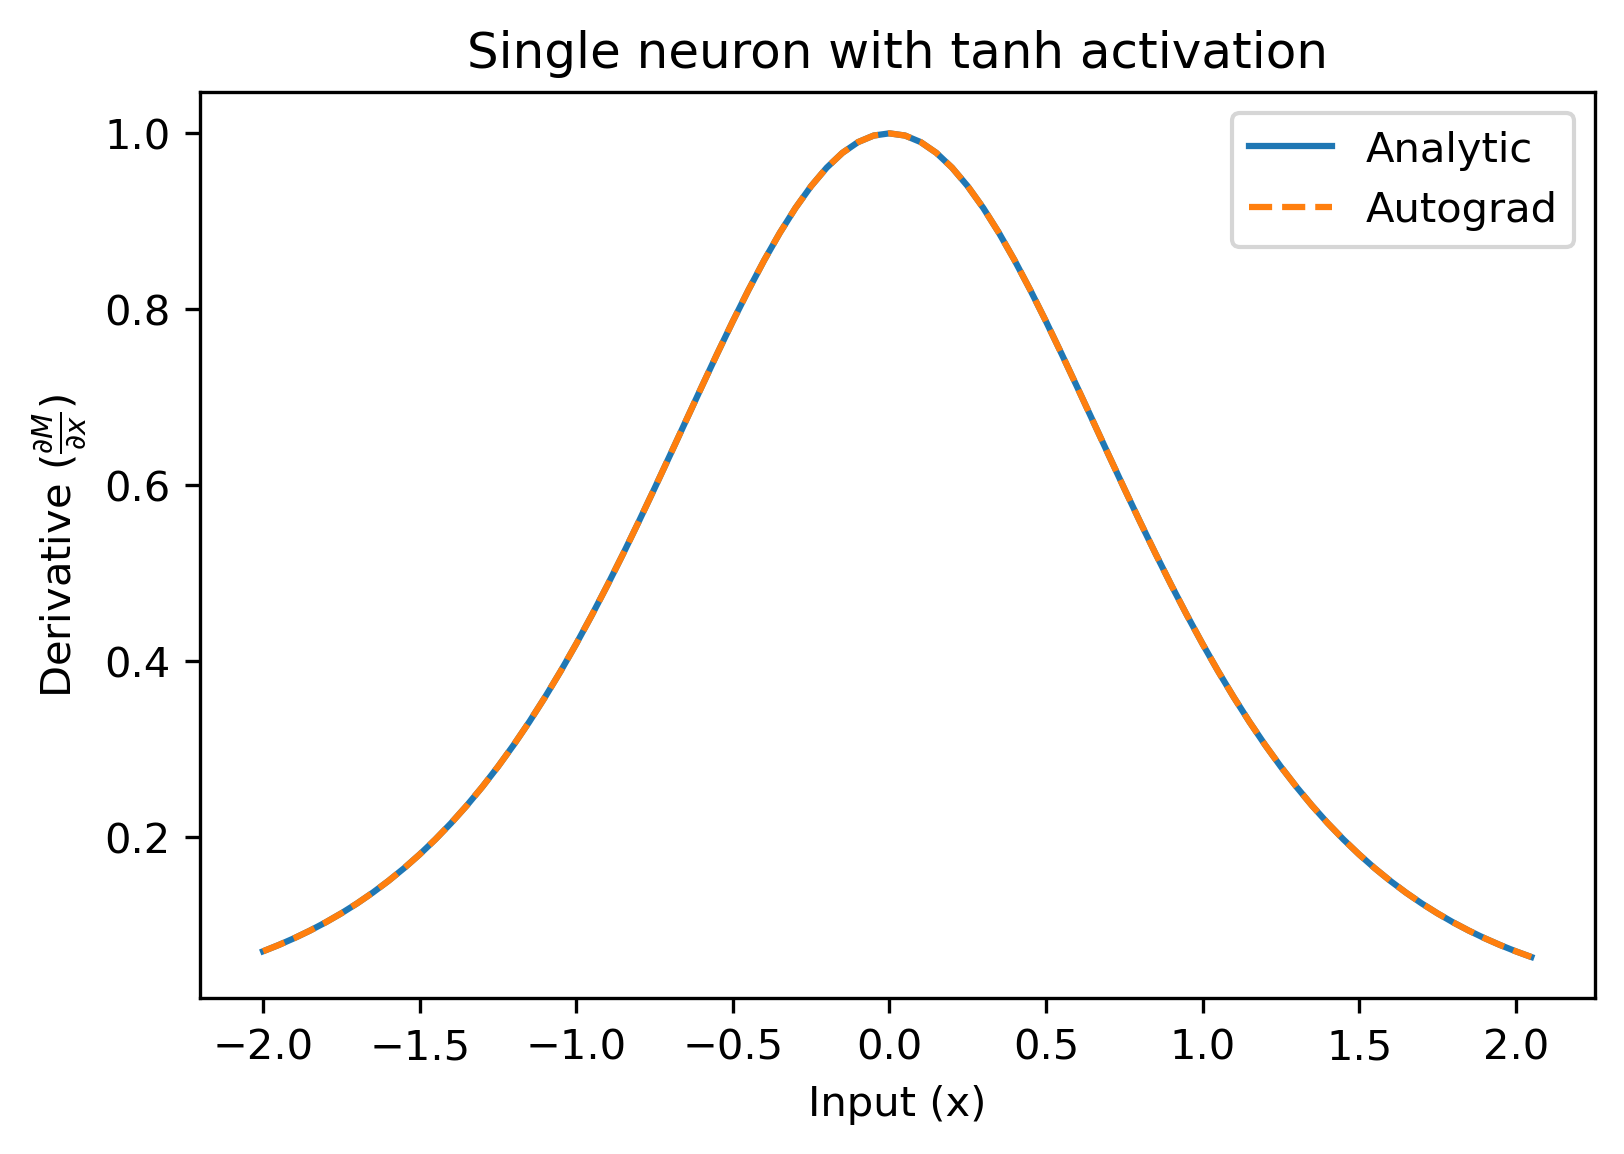

In [6]:
m = Neuron(activation=nn.Tanh)
torch_dmodel_v = np.hstack([
    jacobian(m, vv.view(-1, 1)) for vv in v
]).squeeze()

truth_dtanh_v = dtanh(v)

plt.plot(v, truth_dtanh_v, label='Analytic')
plt.plot(v, torch_dmodel_v, linestyle='--', label='Autograd')
plt.xlabel('Input (x)')
plt.ylabel(r'Derivative ($ \frac{\partial M}{\partial x}$)')
plt.legend()
plt.title('Single neuron with tanh activation')

Now that we are getting more confident, let's do a two layer (each with single neurons) network of a ReLU activation followed by a hyperbolic tangent activation. Each of the linear layers still have the `weight` and `bias` set to 1 and 0, respectively. Thus, we can write the mathematical function that the network performs to be:

$$
f(x) = tanh(ReLU(x))
$$

So, calculating the derivative via the chain rule we have:

$$
\frac{df}{dx}(x) = \frac{d}{dx}\left( ReLU \circ tanh \right)(x) = \frac{dReLU}{dtanh} \frac{dtanh}{dx}(x) = \frac{dReLU}{dx}(x) \cdot \frac{dtanh}{dx}(x)
$$

As we see from the code below, this is reproduced by running the `jacobian` function on our neural network. This shows that the autodiff implementation can work through deeper networks besides a single layer, as it should. 

Text(0.5, 1.0, '2 layer (relu, tanh)')

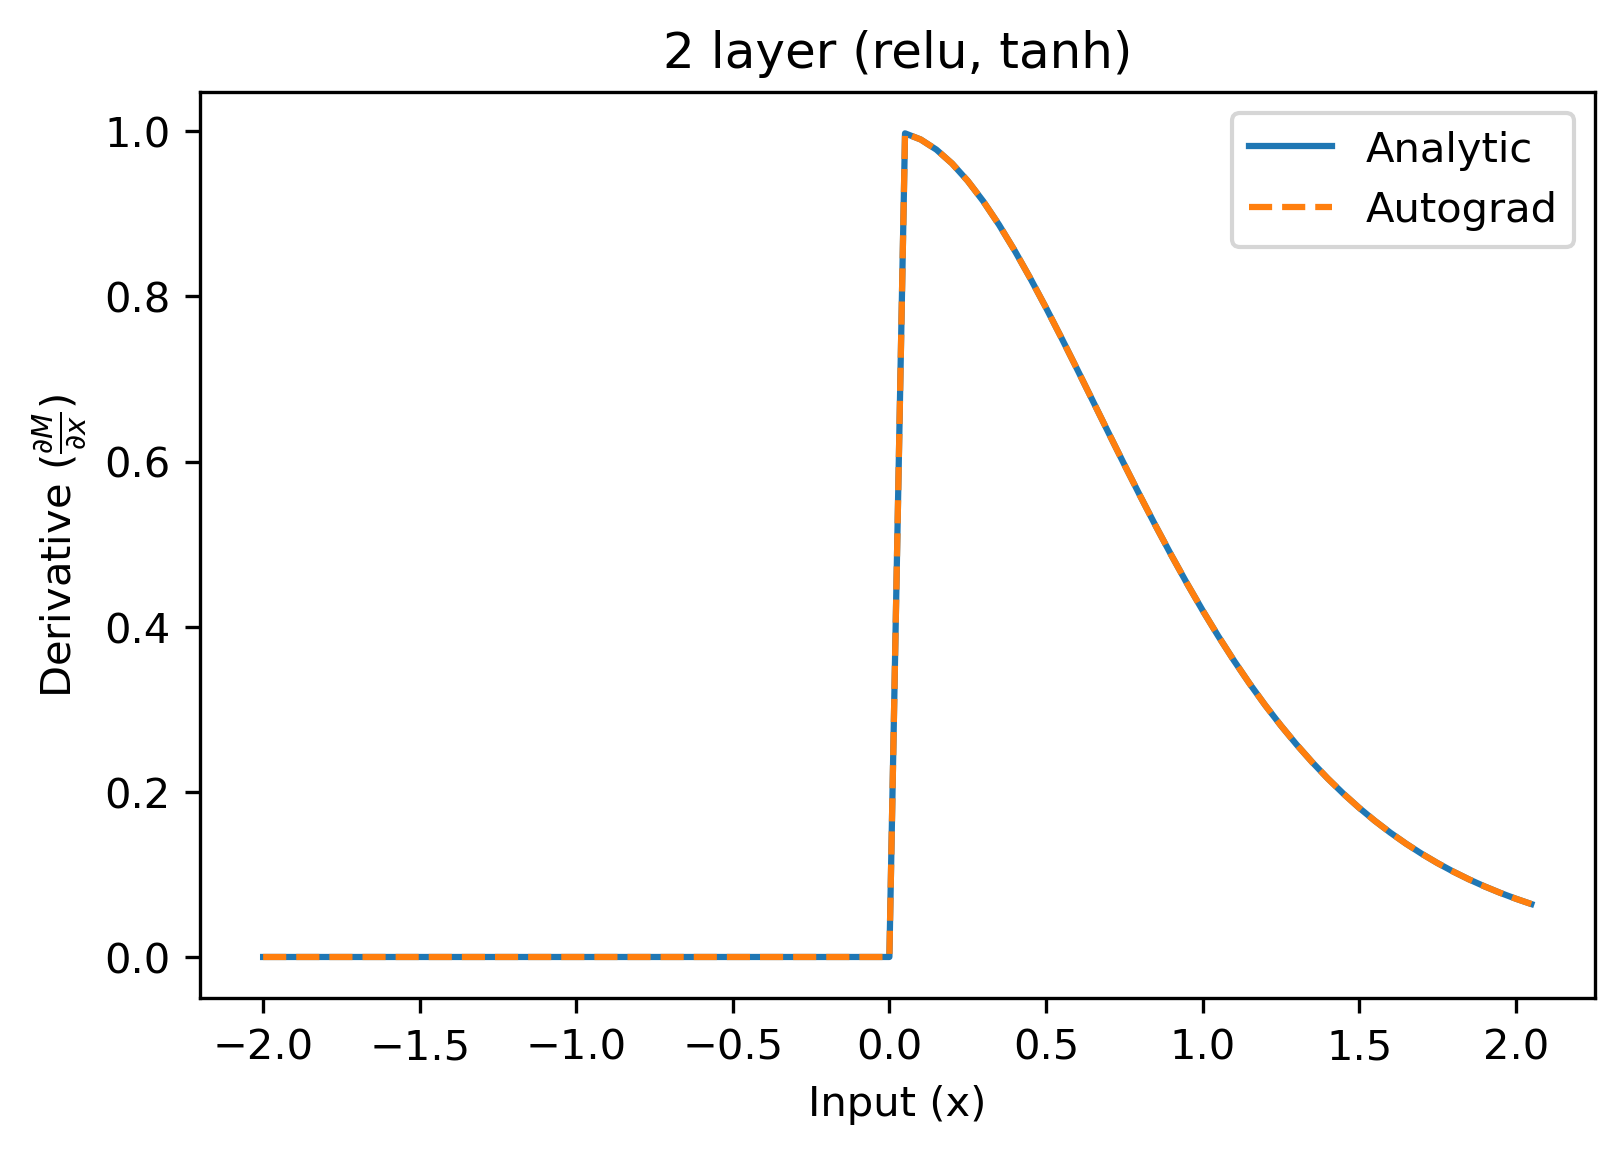

In [7]:
m2 = nn.Sequential(Neuron(nn.ReLU),
                   Neuron(nn.Tanh))
torch_dmodel2_v = np.hstack([
    to_np(jacobian(m2, torch.tensor([[vv]]))) for vv in v])

truth_dmodel2_v = drelu(v) * dtanh(v)

plt.plot(v, truth_dmodel2_v, label='Analytic')
plt.plot(v, torch_dmodel2_v, linestyle='--', label='Autograd')
plt.legend()
plt.xlabel('Input (x)')
plt.ylabel(r'Derivative ($ \frac{\partial M}{\partial x}$)')
plt.title('2 layer (relu, tanh)')

This is not a surprising result, as deep neural-networks are able to be trained via the backpropogation algorithm - but again, it instills confidence that we can use the `jacobian` function for autodifferenentiating complex mathematical constructs that can be assembled with PyTorch. 

If you are still feeling unsure how these principles work you should try writing out the derivatives for networks where the `weight` and `bias` are set to values other than 1 and 0. If you want to get further in the weeds you could try writing a perceptron class which implements multiple neurons in a single layer, and see if you can work out the derivative of such a network with 3 neurons with hyperbolic tangent activations, weights of 2, and biases of 1, whose output dimension is 1. For reference, this network implements the mathematical function:

$$
f(x) = 3 \cdot tanh(2x+1)
$$

and the neural network implementing this is:

In [8]:
class SmallPerceptron(nn.Module):
    
    def __init__(self, width=3, weight=2, bias=1, activation=nn.Tanh):
        super().__init__()
        self.width = width
        self.weight = weight
        self.bias = bias
        
        self.linear = nn.Linear(1, width)
        self.activation = activation()
        self.init_parameters()

    def init_parameters(self):
        with torch.no_grad():
            self.linear.weight[:, :] = self.weight
            self.linear.bias[:] = self.bias
            
    def forward(self, X):
        return torch.sum(self.activation(self.linear(X)))

### Extremely brief background on numerical optimization

To progress beyond just implementing existing machine-learning based models that can regress on quantities of interest for hydrology we need to take yet another brief detour. This detour is a bit longer than the previous, but consider it essential to understanding the methods. We want to emphasize that the field of numerical optimization is evolving nearly as quickly as the rest of machine-learning. This section will begin with a quick overview of first-order gradient based optimization, which provides the basis for the most commonly used optimization strategies for training neural-networks (examples include stochastic gradient descent (SGD), Adam, etc). By including them we hope to emphasize that optimization is not unique to machine-learning and data-driven methods, but a core and essential component to performing numerical computation of complex systems.

From here, we progress to second-order methods, which are the bread-and-butter of introductory numerical analysis and computational modeling courses. These optimization strategies form the backbone of many common numerical ODE and PDE solvers which in turn are almost exclusively what we refer to as "physics-based" models. At this point you might be asking, why are first-order methods implied for neural networks while second-order methods implied for differential equations? This is a good question to ask indeed, but once again beyond the scope of this chapter. We refer interested readers to **Nocedal and Wright (2006), Kochenderfer and Wheeler (2019), Goodfellow et al. (2016), and Isaacson & Keller (1994)**


#### First order methods: Gradient descent and other flavors for training neural networks
The language of optimization is often rooted in topography - if you want to get to the bottom of a valley you must head downhill after all. Simply put, gradient-descent methods are often called first-order methods because they make use of the first derivative (aka the slope of the valley) to find the direction to head towards the optimal point (the bottom of the valley). 

Considering such an approach from an intuitive standpoint brings up several questions - should I always go in the direction of the steepest slope? How far should I continue before considering changing to another direction? When is it okay to go up instead of down? These are predominantly the questions that the different popular optimization strategies for training neural networks are concerned with, albeit in a more formalized mathematical sense than we've let on here. To get away from the intuitive and into the formalism, if we are trying to minimize a function $f$ we ought to head in the opposite direction of the gradient $\nabla f$. To do so we might choose a direction, $d$, that maximizes the gradient via:

$$
d(x) = - \frac{\nabla f(x)}{||\nabla f(x)||}
$$

where $|| \cdot ||$ implies the Euclidean norm (also known as the squared error). Using the previous implementation of the autodiff derivative/gradient you might see how we can implement this in code. However, our implementations have been for scalar (or one-dimensional) functions, and this becomes a very difficult problem when going to higher dimensions.

In practical machine-learning optimization strategies a number of things have become standard to make optimizing large neural-networks possible. First, the actual gradient calculation is often approximated to reduce the computational burden of computing high-dimensional gradients (computational cost is also a main reason for reaching for first, rather than second-order methods for training neural-networks). Additionally the learning rate, or roughly amount of time that you walk in the downhill direction before changing course is often not fixed. This is implemented in different ways for different methods, but popular choices include Adam and RMSProp (**Kingma and Ba, 2014; Ruder, 2017**). Another view on augmenting the speed at which the optimizer heads downhill is the concept of momentum, which operates in line with the physics-basis of the terminology. Optimization steps with high-momentum tend to be difficult to change direction rapidly, which is favored when the topography of the optimization landscape is relatively smooth. On the other hand, low-momentum steps should be adopted when the optimization landscape is very jagged, meaning each step is important to consider to make sure the optimization doesn't get trapped in a local minimum or overshoot out of the valley and into the mountains.

#### Second order methods: Standards for numerical solutions to differential equations
Many questions of first-order optimization can be answered by second-order optimization, but with a very large number of caveats. As first order optimization uses the first-derivative to find the direction of search, second order methods use the second derivative to determine the search strategy.  Recall how the first-order optimization strategies implied questions of how far and which direction to actually step - second-order strategies alleviate some of these concerns by providing information about not only the slope of the optimization landscape but also the curvature.  The basis for second-order methods is called *Newton's method* and can be implemented for a scalar value function $f$ first by taking the second-order expansion about a test-point $x^i$

$$
\hat{f}(x)\approx f(x^i) + (x-x^i)f'(x^i)+ \frac{(x-x^i)^2}{2}\cdot f''(x^i)
$$

Using this equation we can iterate an update equation until some tolerance has converged or a maximum number of iterations has occurred. For the $(i+1)th$ step of the iteration process the iteration becomes:

$$
x^{(i+1)} = x^{(i)} - \frac{f'(x^{(i)})}{f''(x^{(i)})}
$$

Newton's method will converge quadratically, much faster than the linear convergence of first-order methods, provided some very specific criteria are met. These criteria often revolve around choosing the initial test point $x^{(0)}$ as well as the curvature of the function being optimized. Newton's method is notoriously simple to derive but difficult to make work in practice, meaning it is only used in its simplest form in simple applications. Many extensions of Newton's method exist but are beyond the scope of this chapter. Generally, we urge scientists not to roll their own numerical solvers, and to rely on the numerous and well tested packages for solving such problems. However, in our case we must be able to implement numerical solvers in a way that interoperates with autodiff and backpropogation via the PyTorch package. We also want to provide reference implementations that make it clear how the principles operate in code. That said, the `torch.optim` default package implements a host of standard (generally first-order) solvers, `pytorch-optimizers` (`pip` installable as `torch_optimizer`) implements a wide range of other optimizers, and `torchdiffeq` offers some other optimizers for numerically solving differential equations with autodiff capabilities within python, which we will rely on in later portions of this chapter. 

Below we provide a bare-bones implementation of a Newtwon's method iterative solver for second-order optimization. You will note it takes a function (`f`), it's derivative (`fprime`), a test point (`x`), and some tolerance/iteration criteria. As mentioned before, choice of the test point, `x`, is critical for convergence in complex landscapes. For this reason, as well as computational complexity we will continue to focus on scalar valued functions.

> ### A view of other autodiff packages
> We also would be remiss without mentioning the rapidly developing capabilities of the JAX python framework that provides high performance low-level primitives for autodiff of arbitrary python code and associated frameworks such as haiku, equinox, and diffrax. Similarly we must acknowledge the broader Julia programming language ecosystem which has the excellent Flux.jl and DifferentialEquations.jl packages. Both sets of ecosystems/packages implement performant and state-of-the-art packages for machine learning, numerical analysis, and solving differential equations and arbitrary differential optimization at large.


In [9]:
def newton_solve(f, fprime, x, tol=1e-4, max_iter=100):
    f_test = f(x)
    x_list = [x]
    it = 0
    while torch.abs(f_test.clone()) > tol and it < max_iter:
        x = x - (f_test / fprime(x))
        f_test = f(x)
        x_list.append(x)
        it += 1
    return x

For confidence, let's do an easy one, solving for the minimum of a parabola. We don't have a need for the `jacobian` function, neural networks, or anything fancy, we'll write it out from scratch. To do so we will define the function `f` as well as the hand-done derivative `fprime` explicitly. We will then apply it to a random points on the domain $x \in [-1, 1]$. As you can see from the resulting plot, our initial guess (poorly-chosen by design) is very far off of the minimum while the minimum is, to our eye, very close to the actual minimum of the parabolic function.

In [10]:
f = lambda x: x**2
fprime = lambda x: 2*x

x_init = torch.tensor(0.95, dtype=dtype)
x_min = newton_solve(f, fprime, x_init)

def plot_newton_solve(f, x_init, x_min, xrange=(-1, 1)):

    x = torch.linspace(xrange[0], xrange[1], 100)
    fx = np.array([to_np(f(torch.tensor([xx]))) for xx in x]).flatten()
    plt.plot(x, fx, color='black')
    plt.scatter(
        x_init.detach().numpy(), f(x_init).detach().numpy(), 
        marker='X', s=100, c='crimson', 
        label='Initial guess'
    )
    plt.scatter(
        x_min.detach().numpy(), f(x_min).detach().numpy(), 
        marker='X', s=100, c='green', 
        label='Minimum found by Newton solver'
    )
    plt.legend()
    plt.axis('off')

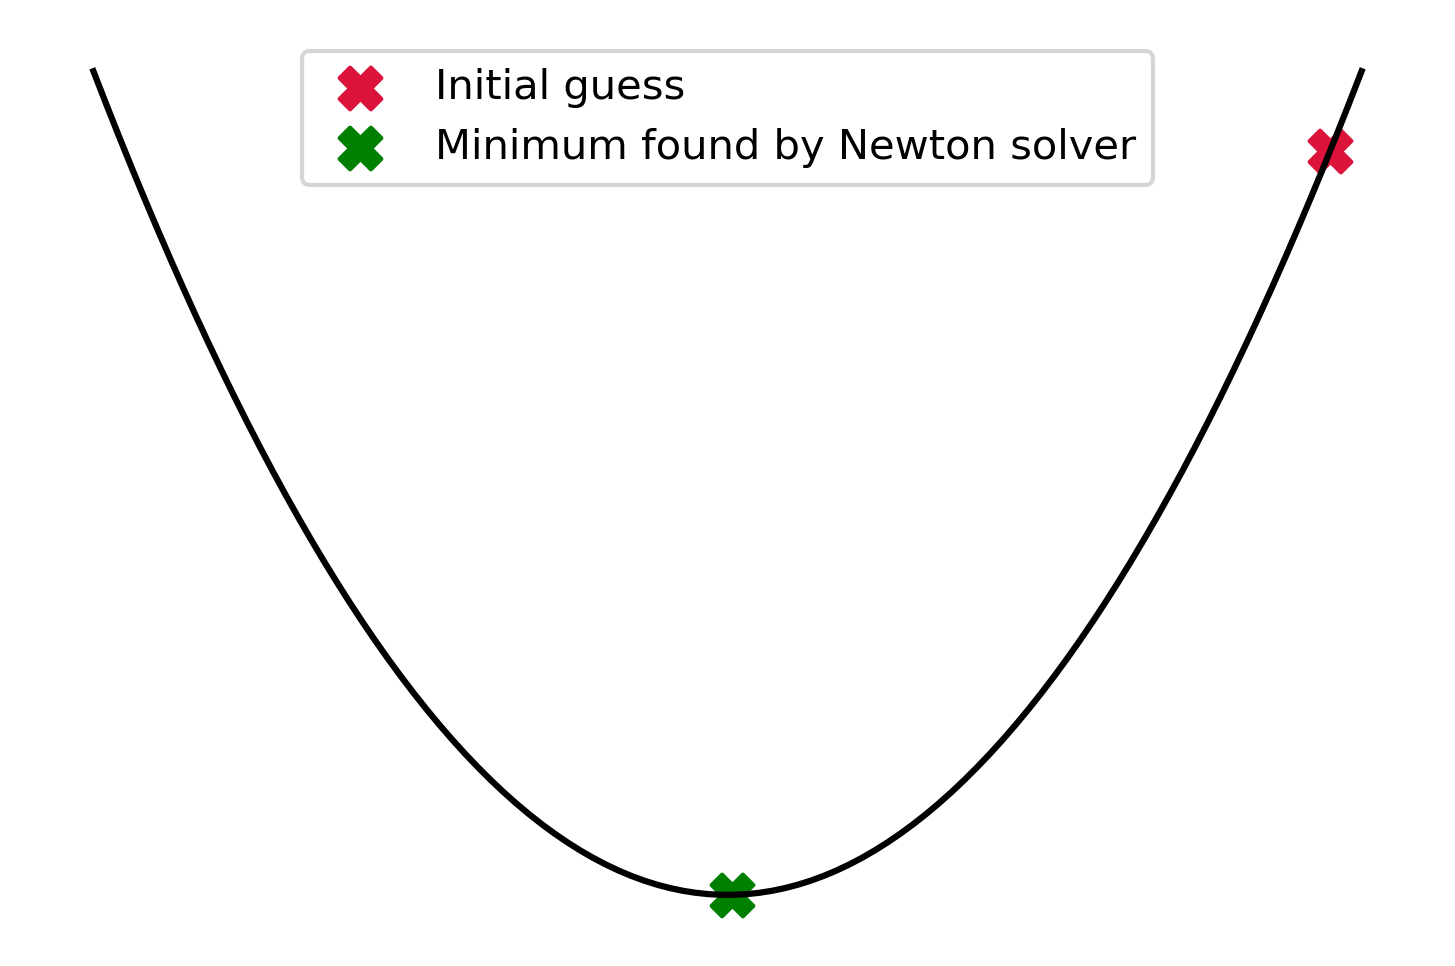

In [11]:
plot_newton_solve(f, x_init, x_min)

Now let's test the solvers on a simple "neural net" defined by a new `nn.Module`. Keep in mind here the question is - can we use traditional numerical optimization techniques on top of the broader autodiff frameworks that are used to train neural networks. To make this work, we'll need to define a neural network which is likely not useful in any real setting. Let's call it `TroughLayer` because it essentially represents a "trough" where there is a low point in the middle of the domain surrounded by high walls. This is a carefully designed network with two sigmoid neurons whose weights and biases were chosen so that the output is what we want. The definition of the `TroughLayer` follows below.

In [12]:
class TroughLayer(nn.Module):
    
    def __init__(self, activation=nn.Sigmoid):
        super().__init__()
        self.layer = nn.Linear(1, 2)
        self.activation = activation()
        self.init_parameters()
        
    def forward(self, x):
        x = self.layer(x)
        x = self.activation(x)
        x = torch.sum(x)
        return x
    
    def init_parameters(self):
        self.layer.weight = nn.Parameter(
            torch.tensor([[  1.5], [ -1.5]])
        )
        self.layer.bias = nn.Parameter(
            torch.tensor([-12.0, -12.0])
        )

Despite being a contrived setup, we can take the `jacobian` function and apply it to the network to get `fprime` so that we can put it into the Newton solver. As you will see, we find a generally good minimum. There was some tuning of the tolerance here, if you set it too low you will diverge. This "network" encodes a function that is quite hard for the standard Newton iteration to converge on a the global minimum. As an exercise, you should try different values of `x_init` as well as determining when it converges with respect to the actual derivative (and second derivative if you're ambitious). This function should give you a good overview of some of the difficulties of numerical optimization in a 1-d setting. In the meantime we can simply bypass these concerns because *most of the time it works*.

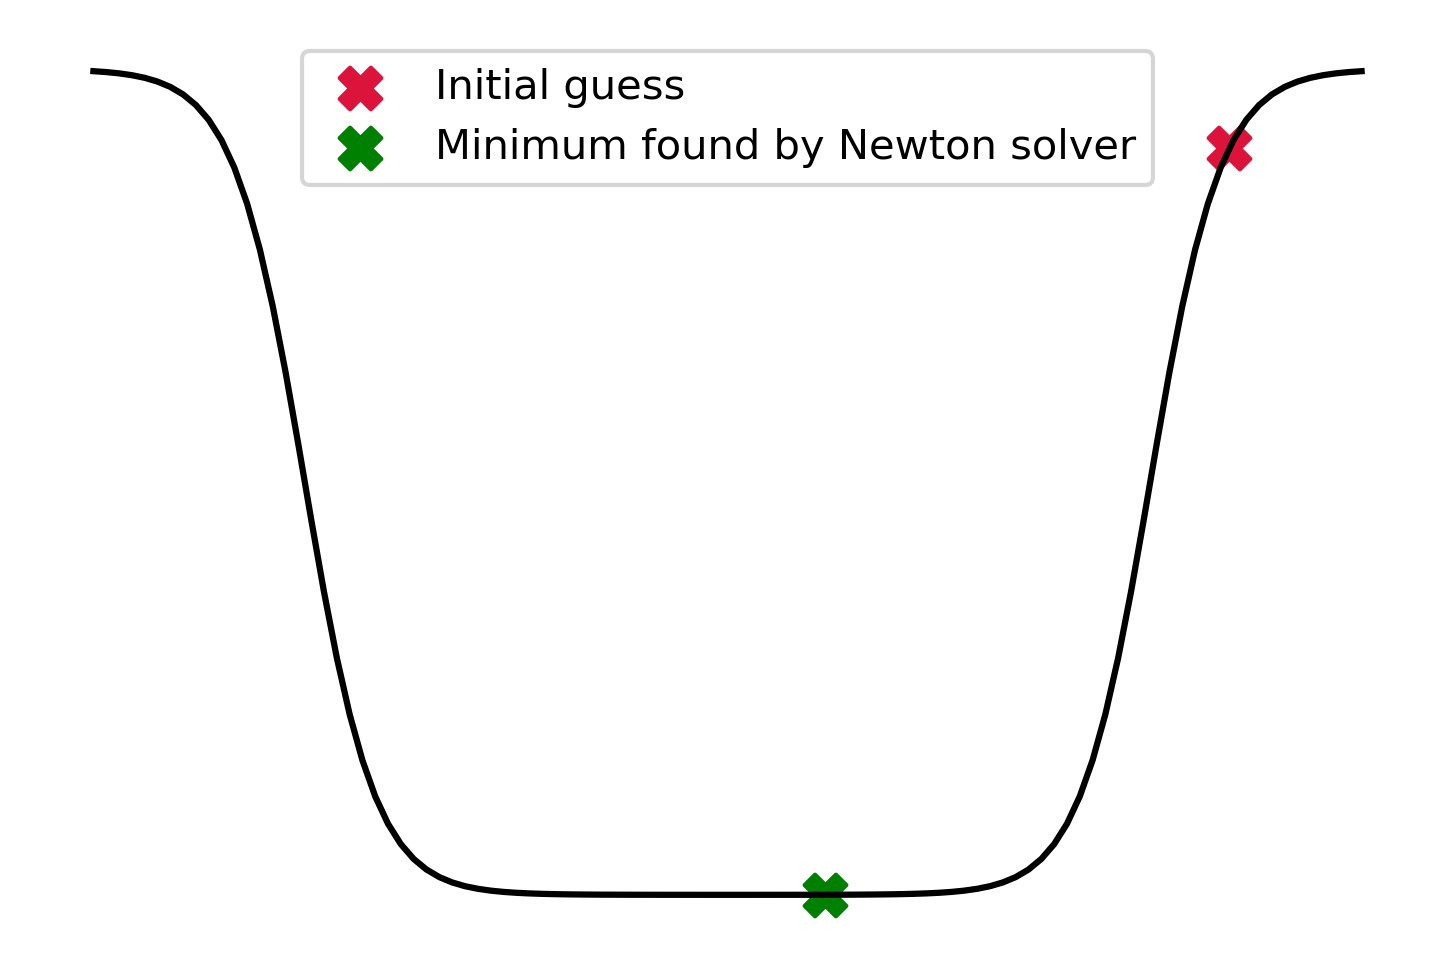

In [13]:
# Define the surface to look for the minimum of
m = TroughLayer()
# Take the derivative of the model
dm_dx = partial(jacobian, m)
# Initial guess
x_init = torch.tensor([9.5], dtype=dtype)
# Use newton solver to find the minimum
x_min = newton_solve(m, dm_dx, x_init)
# Plot the results
plot_newton_solve(m, x_init, x_min, (-12.0, 12.0))

### Brief detour on numerically solving ODEs
At this point you might be wondering what all of this curve traversing is about. Finally time to bring it back - we're trying to merge some machine learning methods with hydrologic modeling methods. As always, we should begin by starting with the simplest approach. To do so we'll describe the linear reservoir model, implement it with the tools we've built up, and show how we can easily solve it. However, it's worth pointing out that the model we will develop here still does not quite get us to a useful hydrologic model at a catchment scale. This is because a single linear reservoir cannot capture the richness of topography and vegetation that we see in the real world. But, it does provide a useful stepping stone towards more complex models. Once we have seen we can numerically solve the linear reservoir model with the tools we've built up we'll relax the constraint of linearity. We will show that we can learn a nonlinear conductivity curve for a reservoir operation release in this idealized model using a hybrid physics/data-driven approach. Let's get started!

#### The hydrologist's favorite: The linear reservoir model

It's the hydrologist's favorite model! We can pretty easily solve this one analytically, so let's use it to make sure that our solvers are capable of producing good solutions. The linear reservoir model is given by the equation:

$$
\frac{dS}{dt} = k \cdot S(t)
$$

where $S(t)$ is the storage of the reservoir at time $t$ and $k$ is the reservoir conductivity constant with units $1/t$. For fixed values of $k$ we can solve this equation analytically, as it's simply an exponential:

$$
S(t) = S(0) \cdot e^{k\cdot t}
$$

where $S(0)$ is the initial storage. You should verify that this equation satisfies the original differential equation. You might note that if $k$ is positive, we get exponential growth and if $k$ is negative we get exponential decay. In line with some physical intuition, the $k$ value in a "hydrologically-flavored" reservoir should be negative, as the water will drain out. To see an example of this, along with comparison of our implementation of a numerical solution using Newton's method we will select $k=-0.1$ and $S(0)=1.0$. To solve the equation we will use the implicit, or backward, Euler method, which is one of the simplest methods for numerically solving differential equations. We can estimate the storage at some time $t_{i+1}$ given the current storage at time $t_i$ as:

$$
S(t_{i+1}) = S(t_{i}) + \Delta t \cdot \left( k \cdot S(t_{i+1}) \right)
$$

Given this equation, you might see the problem, $S(t_{i+1})$ is on both sides of the equation, meaning we must make an optimization step to iteratively solve for $S_{i+1}$. This is where Newton's method comes in. We can frame this problem as a Newton iteration by rearranging the equation to:

$$
\begin{aligned}
0 &= S(t_{i+1}) - S(t_{i}) - \Delta t \cdot \left(k \cdot S(t_{i+1}) \right)
\end{aligned}
$$

This equation will be supplied to the Newton iteration (defined as `f` below). This function is also easy enough to take the derivative of with respect to $S(t_{i+1})$, which we define as `fprime` for the sake of example. We also compute an autodiff variant of this derivative to show how we don't need to always hand-calculate the derivatives for every problem we want to solve.

As you can see we can solve this equation pretty well numerically. Sure, there is some discrepancy, but this is mainly showing how to get an end-to-end solution, rather than fine tuning each piece. Let's call this good enough and move on because there's no need to do any machine learning here.

Text(0, 0.5, 'storage')

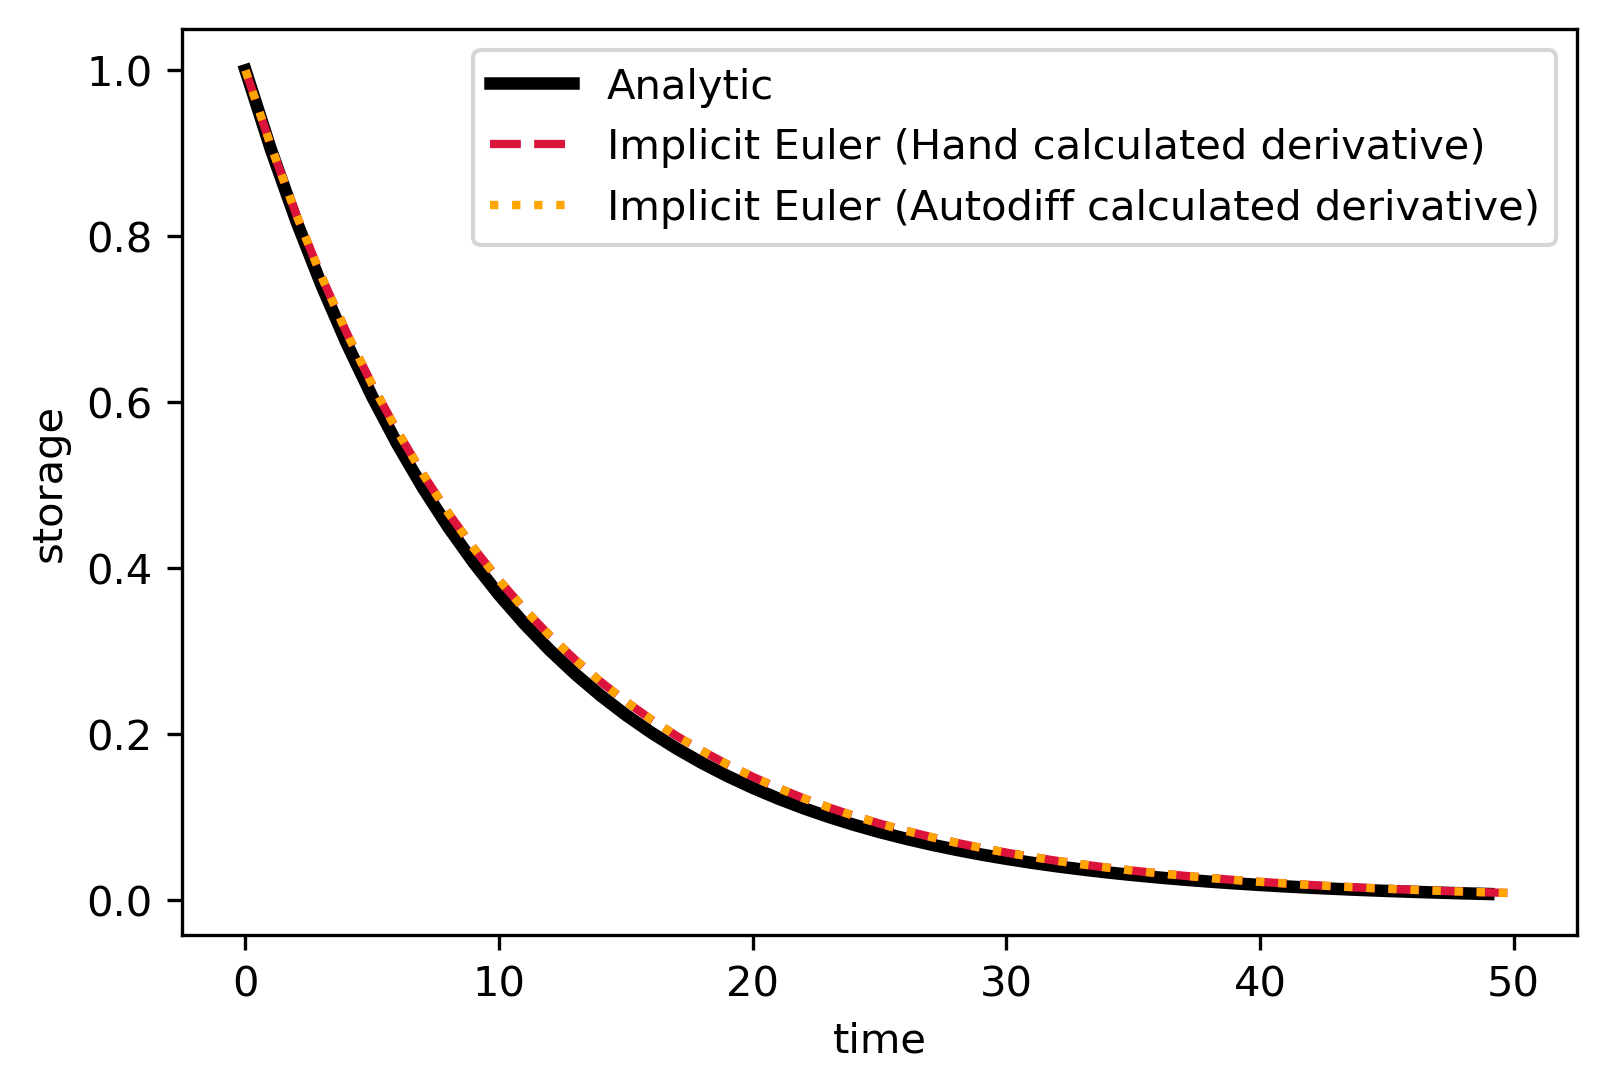

In [14]:
# Reservoir constant
k = -0.1

# Initial value
S0 = torch.tensor(1.0, dtype=dtype)
N_time = 50

# Analytic solution
t_range = np.arange(N_time)
S_analytic = S0 * np.exp(k * t_range)

# Format the ODE for the Newton solver
def f(x, S, k):
    return x - S - k * x

# Derivative of the equation above
def fprime(x, S, k):
    return 1 - k

# Start with the initial value
S_newt = [S0]
S_newt_ad = [S0]

for i in range(N_time):
    # Partials are getting rid of the initial condition and parameter args
    fprime_Sk = partial(fprime, S=S_newt[-1], k=k)
    f_Sk = partial(f, S=S_newt[-1], k=k)
    # Calculate the update
    S_newt.append(newton_solve(
        f_Sk,             # Function with conditions at current time
        fprime_Sk,        # Derivative with conditions at current time
        (1+k)*S_newt[-1]) # Initial guess - I just made this one up
    )
   
    # Now do the same, but with an autodiff calculated derivative
    fprime_Sk_ad = partial(jacobian, f_Sk)
    S_newt_ad.append(newton_solve(
        f_Sk, 
        fprime_Sk_ad, 
        (1+k)*S_newt[-1])
    )

plt.plot(S_analytic, color='black', linewidth=3, label='Analytic')
plt.plot(S_newt, color='crimson', linestyle='--', linewidth=2, 
         label='Implicit Euler (Hand calculated derivative)')
plt.plot(S_newt_ad, color='orange', linestyle=':', linewidth=2, 
         label='Implicit Euler (Autodiff calculated derivative)')
plt.legend()
plt.xlabel('time')
plt.ylabel('storage')

### Bringing things together: Solving ODEs inside of neural networks

#### The nonlinear reservoir model

As we said, the linear reservoir is too easy and doesn't involve much uncertainty that would require any extra fancy machinery. So, to get there, let's change the ODE so that the conductivity term, K, is now dependent on the current storage. We will use the conductivity term as:

$$
K(x) = -0.1 \cdot \text{tanh}\left( 10\cdot(x-0.5) \right)
$$

This represents a conductivity term where, basically, if you have low storage you start filling up and if you have high storage you start draining. Steady state is at a nice even value of 0.5. We encode this into our function `kx` below, and then run it for a bunch of values ranging from 0 to 1 to see the actual curve. The plot is output from the next code cell. Again, values above 0 correspond to the reservoir draining and values below 0 correspond to the reservoir filling.

Text(0, 0.5, 'Reservoir conductivity (K)')

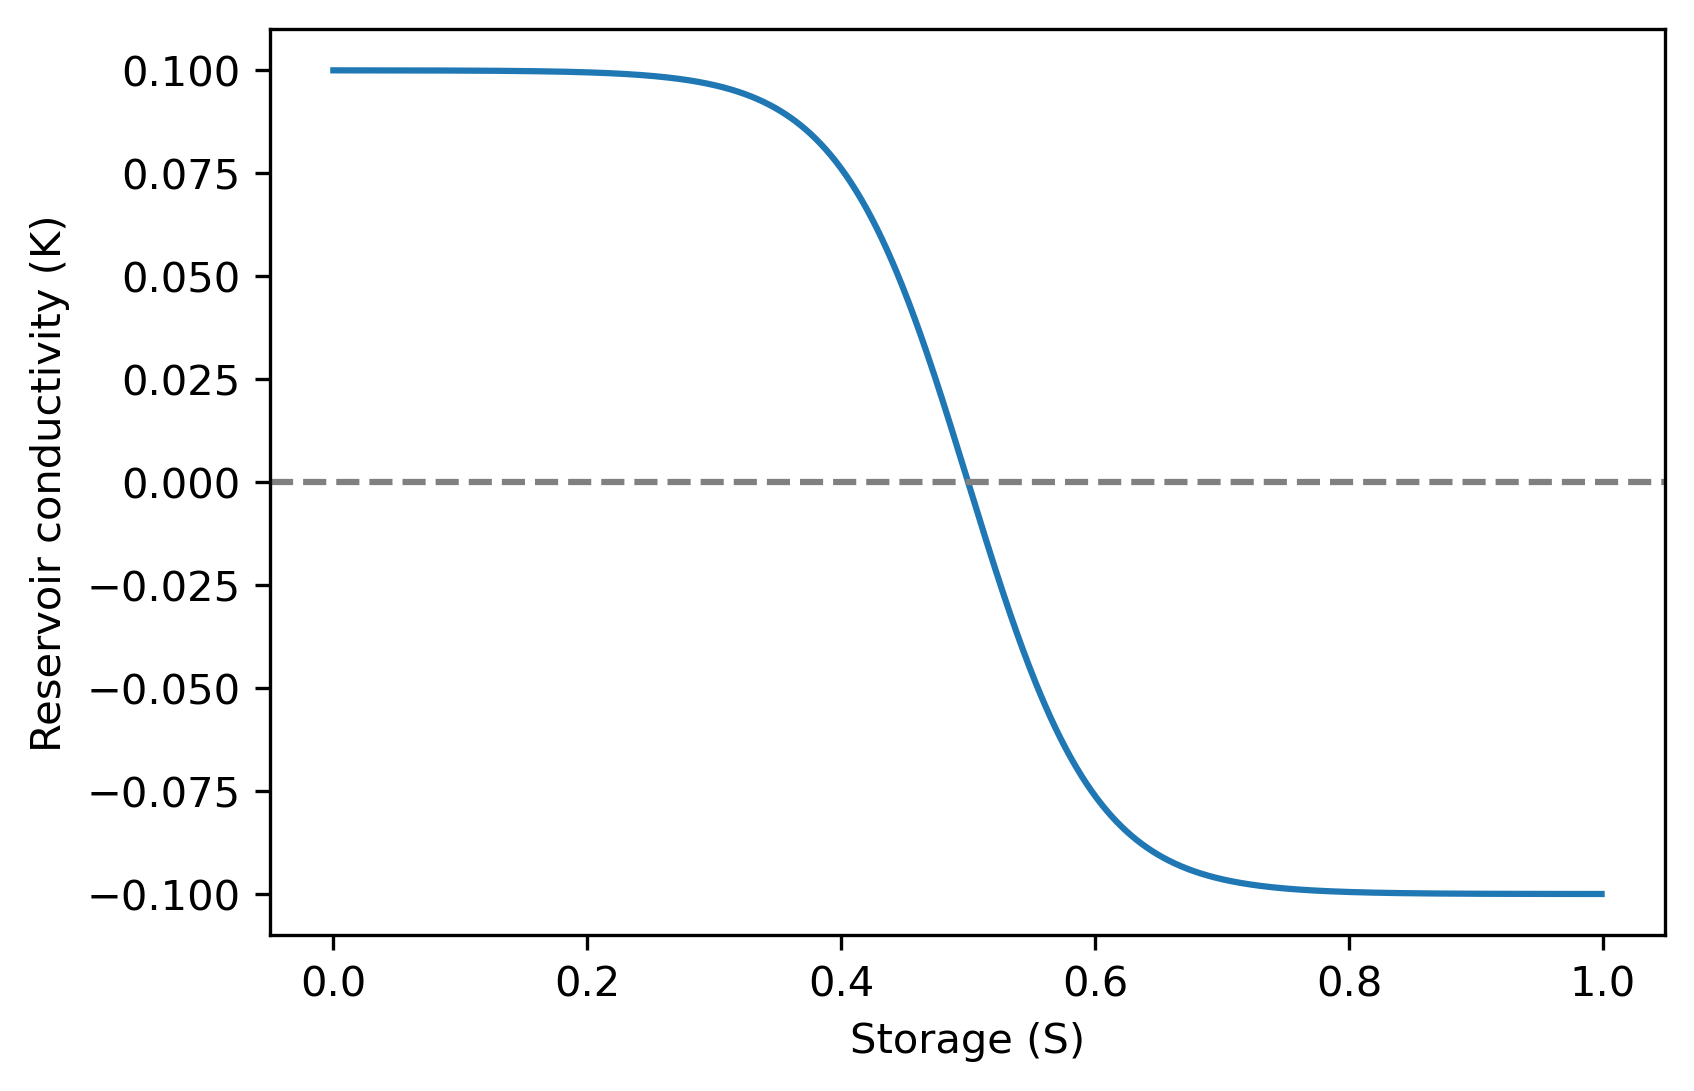

In [15]:
v = torch.tensor(np.arange(0.0, 1.0, step=0.001), dtype=dtype)

def kx(x, b=0.50, s=-0.1):
    return s * torch.tanh(10 * (x-b))

plt.plot(v, kx(v))
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel('Storage (S)')
plt.ylabel('Reservoir conductivity (K)')

Given all of our machinery developed so far, we can now solve the nonlinear version for all sorts of initial conditions. Note that I am using autodiff's `jacobian` to determine the derivative of the conductivity function $K(S)$, but there's also a commented out version of the solver.

Text(0, 0.5, 'storage')

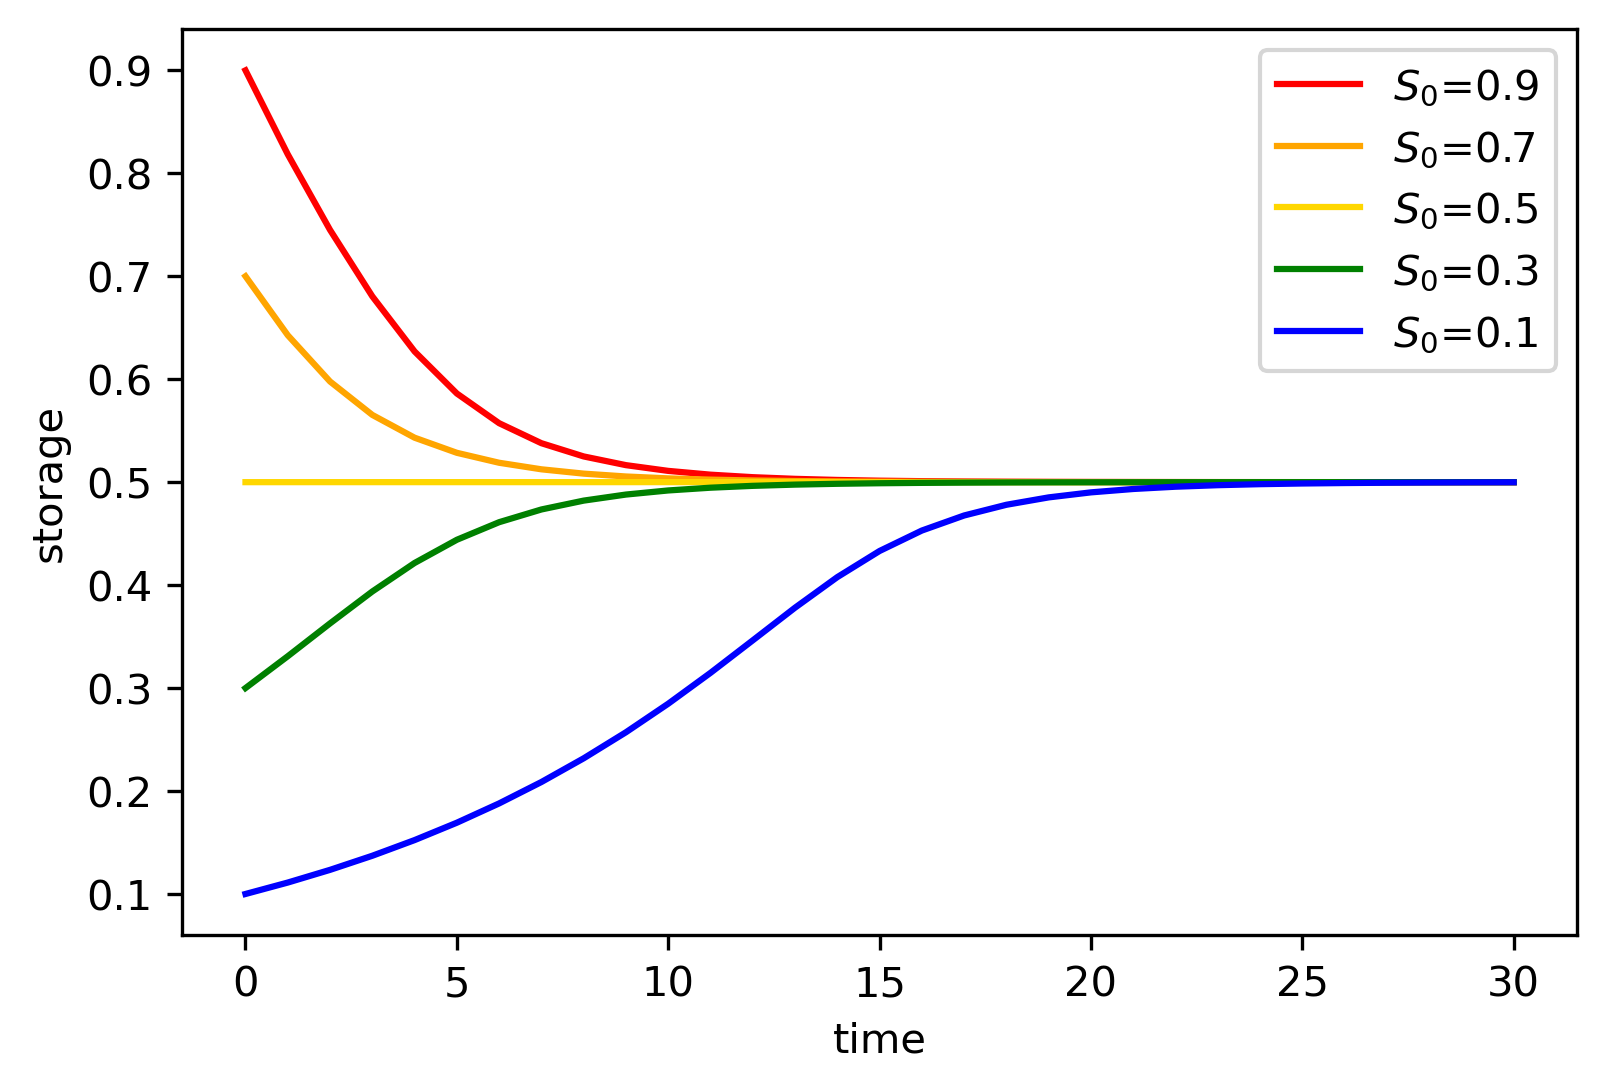

In [16]:
def f(x, S, k):
    return x - S - k(x)*x

def fprime(x, S, k):
    return 1 - jacobian(k, x) * x - k(x)

def my_odeint(f, fprime, S_newt, kx, N_time=30):
    for i in range(N_time):
        f_Sk = partial(f, S=S_newt[-1], k=kx)
        # "hand done" derivative function
        #fprime_Sk = partial(fprime, S=S_newt[-1], k=kx)
        # autodiff derivative function
        fprime_Sk = partial(jacobian, f_Sk)                  
        S_newt.append(newton_solve(f_Sk, fprime_Sk, (1+k)*S_newt[-1]))
    return S_newt

all_S_newt = []
for S0 in [0.9, 0.7, 0.5, 0.3, 0.1]:
    all_S_newt.append(my_odeint(f, fprime, [torch.tensor(S0)], kx))

plt.plot(all_S_newt[0], color='red',    label='$S_{0}$=0.9')
plt.plot(all_S_newt[1], color='orange', label='$S_{0}$=0.7')
plt.plot(all_S_newt[2], color='gold',   label='$S_{0}$=0.5')
plt.plot(all_S_newt[3], color='green',  label='$S_{0}$=0.3')
plt.plot(all_S_newt[4], color='blue',   label='$S_{0}$=0.1')
plt.legend()
plt.xlabel('time')
plt.ylabel('storage')

#### Learning the reservoir conductivity function with neural networks
Now imagine you're actually a hydrologist - you can't directly measure the conductivity of the "reservoir" but you can measure storage levels. If you're interested in determining $K(S)$ from data you have all sorts of avenues, but the one we're interested in is a neural network. In this case, imagine we "know" what the dynamics look like (aka the general structure of the ODE defining the system), but we do not know the functional form for $K(S)$. Our neural network then, will solve the dynamics, and update the weights of a network that represents the conductivity during training. Once trained, we can pull out the network and look at what $K(S)$ was determined to be from the data. 
Below is the network in question. Note it's just a simple densely connected network with `width` and `depth` hyperparameters. You might modify this to be a more complex structure, but for simplicity let's give this a go.

In [17]:
class MLP(nn.Module):
    """A basic Multi Layer Perceptron model"""
    
    def __init__(
        self, 
        width, 
        depth, 
        activation=nn.Tanh,
        in_dim=1,
        out_dim=1,
        bias=True,
        linear=nn.Linear,
    ):
        super().__init__()
        self.layers = []
        self.layers.append(linear(in_dim, width, bias=bias))
        for i in range(depth):
            self.layers.append(linear(width, width, bias=bias))
        self.layers.append(linear(width, out_dim, bias=bias))
        self.layers = nn.ModuleList(self.layers)
        self.activation = activation()
        self.out = nn.Identity()
        
    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        x = self.out(self.layers[-1](x))
        return x


class NeuralReservoir(nn.Module):
    """
    A module representing the Nonlinear reservoir with a 
    conductivity term represented by an MLP
    """
    
    def __init__(self, width, depth):
        super().__init__()
        # Parameterize K(S) as an MLP model
        self.K = MLP(width, depth)
        
    def newton_solve(self, f, fprime, x, tol=1e-4, max_iter=100):
        f_test = f(x)
        it = 0
        tol = torch.tensor(tol, dtype=dtype)
        err = torch.abs(2 * tol) #ensure at least one pass occurs
        while err > tol and it < max_iter:
            x = x - (f_test / fprime(x))
            f_test = f(x)
            err = torch.abs(f_test)
            it += 1
        return x
    
    def res_equation(self, x, S):
        # Reservoir equation (aka the "dynamics")
        return x - S - self.K(x) * x
   
    def forward(self, S0):
        f_Sk = partial(self.res_equation, S=S0)
        fprime_Sk = partial(jacobian, f_Sk) 
        S1_guess = torch.tensor(0.95) * S0
        S_all = self.newton_solve(f_Sk, fprime_Sk, S1_guess).squeeze()
        return S_all
    


Before we can train the network we need some data - this is where we use our previous solution to generate some synthetic data and we will see how well the network can reconstruct the known conductivity function. I'll just run a few timesteps for a bunch of different initial conditions.

In [18]:
n_samples = 10
all_S_newt = []
all_initial_conds = torch.rand(n_samples, dtype=dtype)
for S0 in all_initial_conds:
    all_S_newt.append(my_odeint(f, fprime, [S0], kx, N_time=1))

We will also define a standard `epoch` function whcih simply iterates over the training data and runs the optimization routine (Here, a variant of gradient descent). If you are not familiar with this sort of construct we recommend you go back and work through some basic PyTorch tutorials because designing the training loop is one of the most crucial and common workflows in deep learning.

In [19]:
def epoch(X, y, model, loss_fun, opt, device=device):
    total_loss, total_err = 0., 0.
    n_iter = X.shape[0]
    for i in range(n_iter):
        Xd, yd = X[i].to(device), y[i].to(device)
        opt.zero_grad()
        yp = model(Xd)
        loss = loss_fun(yp.squeeze(), yd.squeeze())
        loss.backward()
        opt.step()
        total_loss += loss.item() * X.shape[0]
    return total_loss / len(X)

### Split out the input/output data

Our networks training task is to figure out the storage one timestep later, given it's initial storage. We have 10 samples for training, but you could add more by adding more `S0`'s under the `Training Data` heading or by increasing the number of timesteps in the `my_odeint` function. You might be thinking 10 samples is way too small to do any machine learning on, but keep in mind we have a *very* strong inductive bias for how our model operates because we've directly encoded the differential equaiton and are only attempting to figure out a parameterization of it. If you bump this number up to 100  or 1000 you will see we can pretty much perfectly match the conductivity curve. But, using only 10 samples is conceptually more interesting as it shows how viable this type of approach can be.

In [20]:
train_X = []
train_Y = []
for ss in all_S_newt:
    train_X.append(ss[0:-1])
    train_Y.append(ss[1:])

train_X = torch.tensor(np.hstack(train_X).reshape(-1, 1), dtype=torch.float32)
train_Y = torch.tensor(np.hstack(train_Y).reshape(-1, 1), dtype=torch.float32)

train_X.shape

torch.Size([10, 1])

### Let's train!

The NeuralReservoir is set up with some user-defined width and depth settings. We additionally set a learning rate for our optimizer (chosen to be Adam) and finally train a user-defined number of epochs. Following training we can look at the loss curve to see if the model was able to converge.

In [21]:
max_epochs = 300
width = 12
depth = 4
# We go big here: https://twitter.com/karpathy/status/801621764144971776?lang=en
learning_rate = 3e-3

model = NeuralReservoir(width, depth).to(device)
loss_fun = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
loss_history = []
for i in tqdm(range(max_epochs)):
    train_loss = epoch(train_X, train_Y, model, loss_fun, opt)
    loss_history.append(train_loss)

  0%|          | 0/300 [00:00<?, ?it/s]

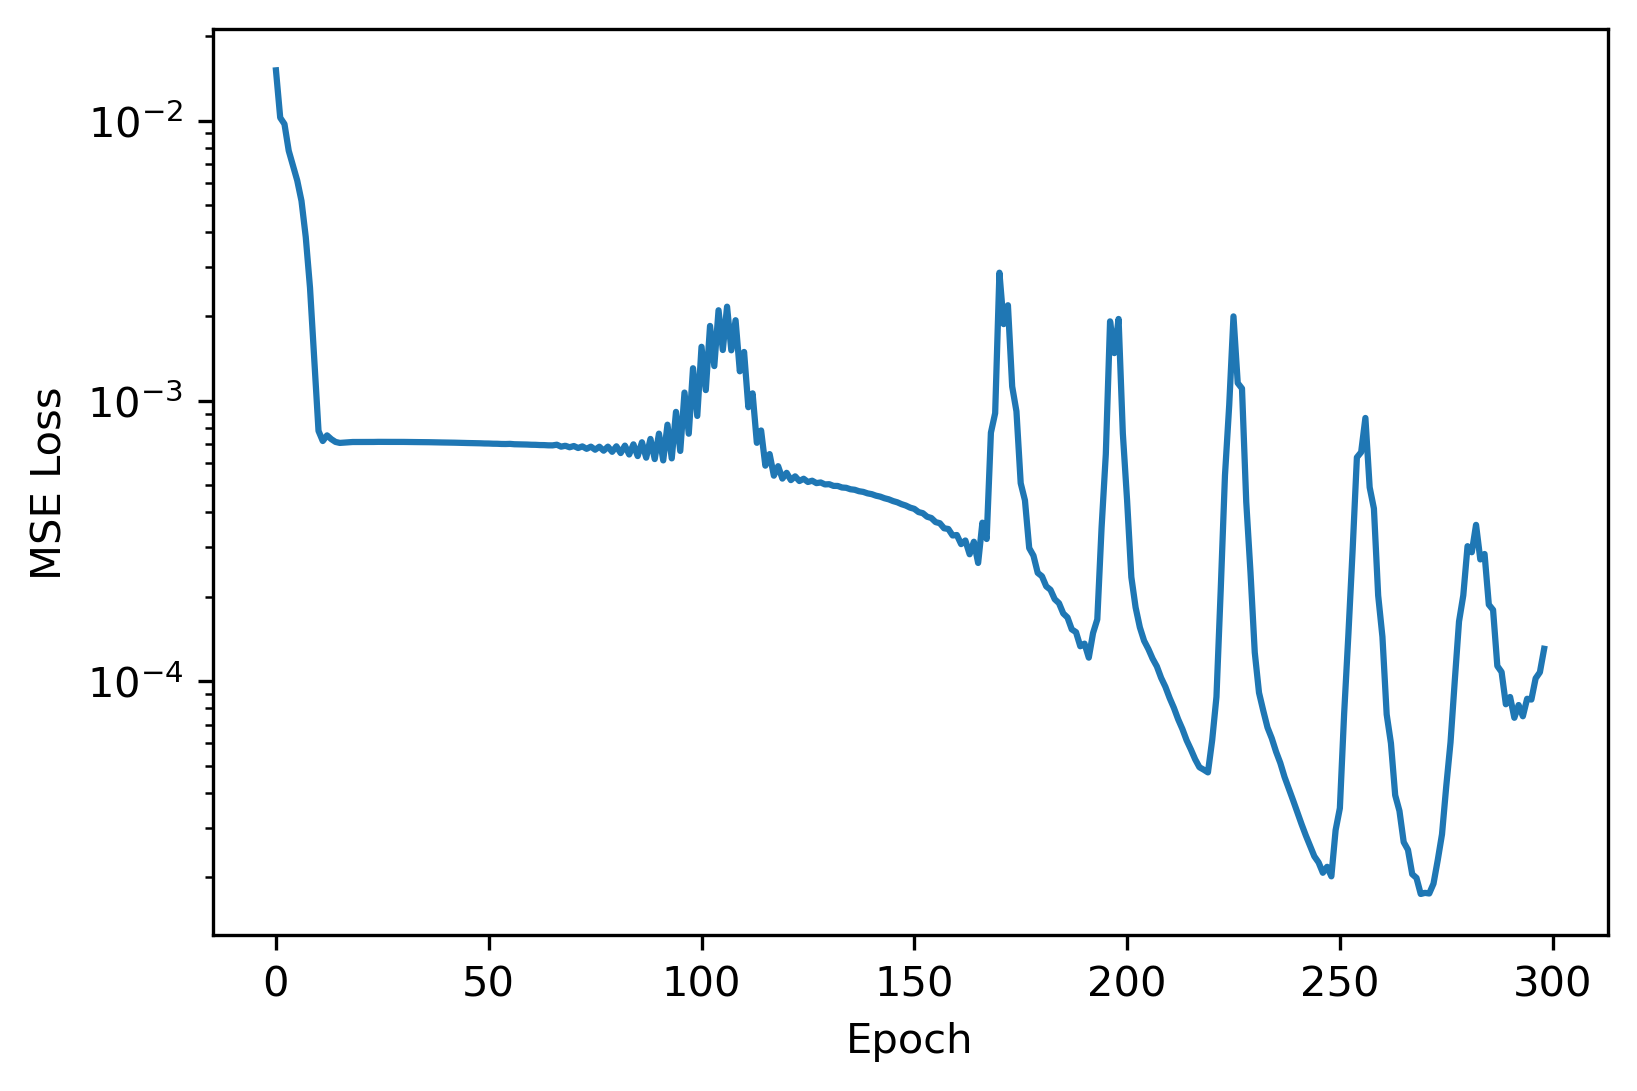

In [23]:
def plot_loss(loss_history):
    plt.plot(loss_history[1:])
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.semilogy()
    
plot_loss(loss_history)

### What did the network actually learn though?

Looking at the loss curve, we can see that the model was able to reduce the loss over a number of epochs, and then started to oscillate in it's performance. It's most certainly possible that the model could be trained to a better overall loss value, but in the interest of conciseness we leave these as possible exercises. Getting back to the question at hand, our network was evaluated on how it was able to predict the next timestep's storage, but we were interested in getting the reservoir conductivity function, $K(S)$, out. Lucky for us, we can just pull it out with `model.K` and start inputting storage values. Let's see how we did!

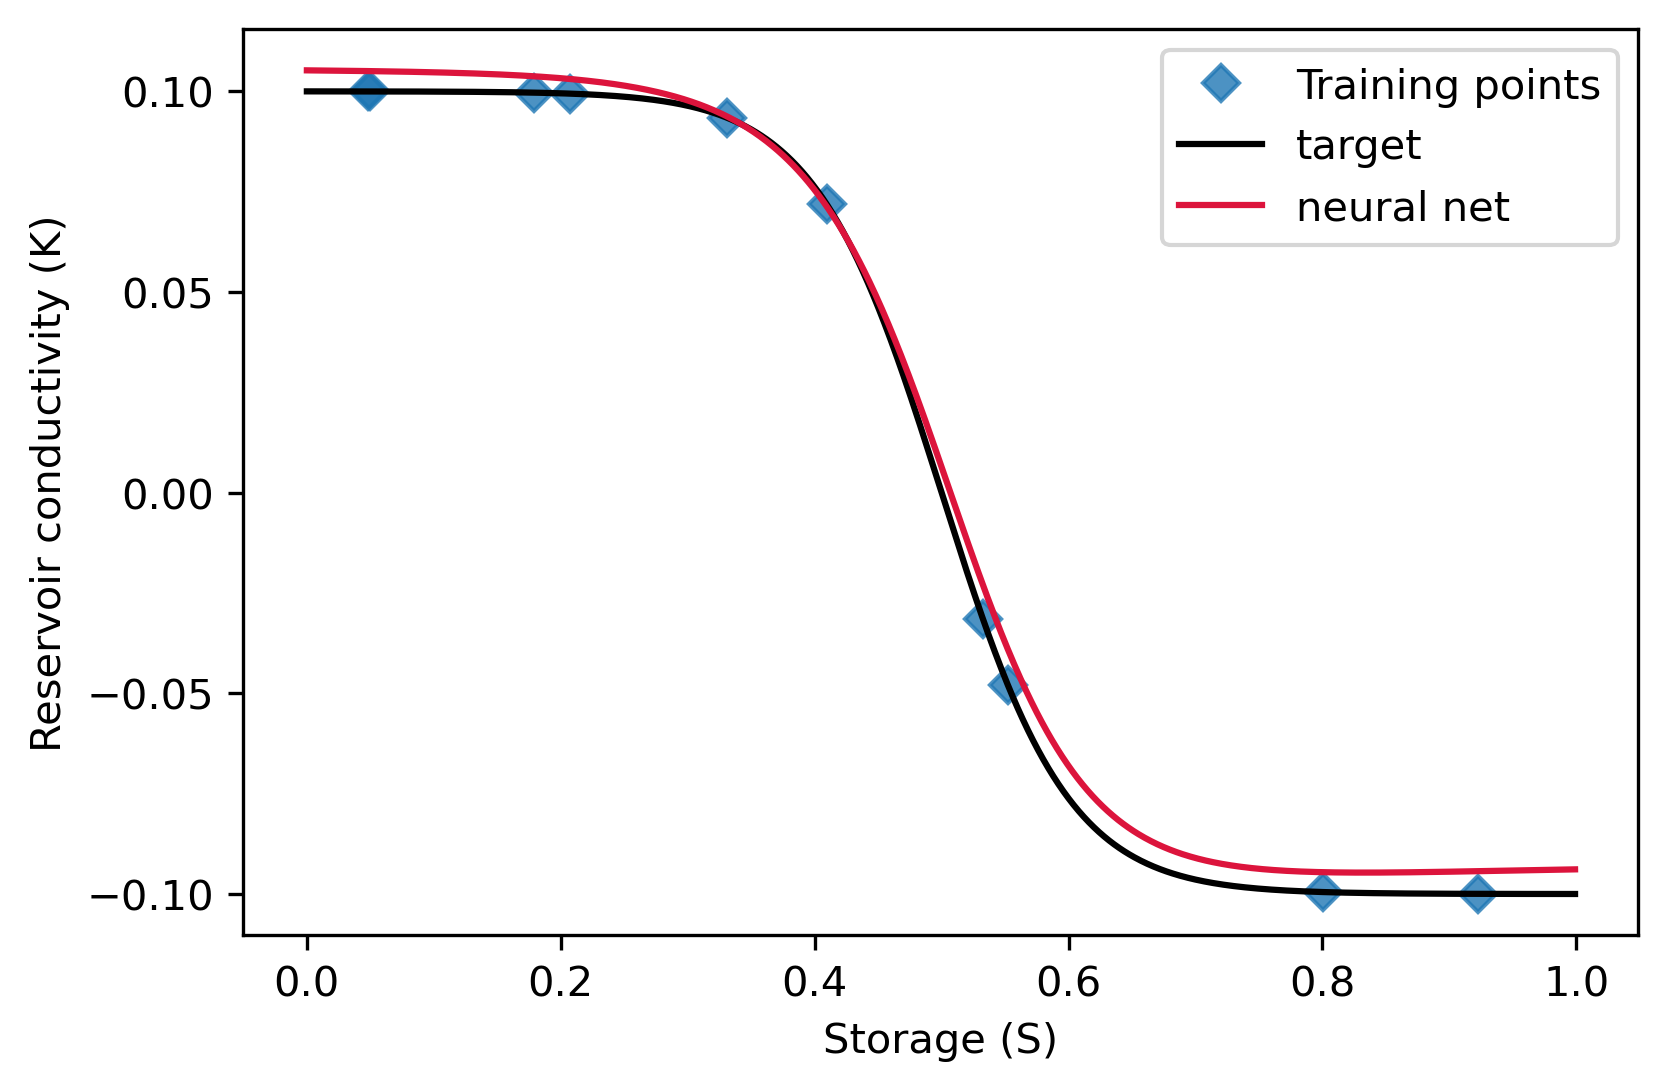

In [24]:
def plot_conductivity(model, v):
    dtype = torch.float32
    model_k = model.K
    yhat = np.hstack([to_np(model_k(torch.tensor([vv]))) for vv in v])
    plt.plot(
        all_initial_conds, 
        kx(all_initial_conds), 
        linestyle='', 
        marker='D', 
        label='Training points', 
        alpha=0.8
    )
    plt.plot(v, kx(v), color='black', label='target')
    plt.plot(v, yhat, color='crimson', label='neural net')
    plt.legend()
    plt.xlabel('Storage (S)')
    plt.ylabel('Reservoir conductivity (K)')
    
v = torch.tensor(np.arange(0.0, 1.0, step=0.001), dtype=dtype)
plot_conductivity(model, v)

### Introducing `torchdiffeq`

Now that you see how we can solve differential equations *inside* of neural networks and still train them it's time to move beyond home-grown solutions. As solving differential equations is quite difficult to get right and the basic methods tend to break down on harder problems mathematicians, scientists, and software engineers have spent a great deal of time developing packages and methods that can be taken "off the shelf". The `torchdiffeq` package (https://github.com/rtqichen/torchdiffeq) developed in recent years allows for many of these numerical solvers to be integrated seamlessly with PyTorch (**Chen et al., 2017**). We can reframe the previous problem of estimating the reservoir constant using this new package quite easily.

To do so, we first package up the ODE in a new `nn.Module` subclass, whose `forward` method simply implements the right hand side of the reservoir equation:

$$
\frac{dS}{dt} = K(S)\cdot S
$$

The constructor on the `ReservoirEquation` class takes in a `K` parameter which we will represent with a multilayer perceptron as before.  Then, we create a new class, `TorchDiffEqNeuralReservoir`, which solves the `ReservoirEquation` via the new `odeint` function which we just imported. There are some extra details here, such as the `solver_method` and `integration_time` which we will not cover directly here, but are explained in the `torchdiffeq` documentation at the link given above.

Anyhow, as you can see the training procedure is nearly identical to before, as is the training time. Similarly, the extracted conductivity curve still looks reasonably close to the target, though it differs qualitatively from the out previous model simply due to the randomness in the training process.

In [25]:
from torchdiffeq import odeint

class ReservoirEquation(nn.Module):
    
    def __init__(self, K):
        super().__init__()
        self.K = K
            
    def forward(self, t,  x):
        return self.K(x) * x


class TorchDiffEqNeuralReservoir(nn.Module):
    
    def __init__(self, width, depth, solver_method='implicit_adams'):
        super().__init__()
        self.K = MLP(width, depth)
        self.res = ReservoirEquation(self.K)
        self.time = torch.tensor([0, 1], dtype=torch.float64)
        self.method = solver_method
        
    def forward(self, x):
        S_all = odeint(self.res, x, self.time, method=self.method)
        return S_all[-1]
 

  0%|          | 0/300 [00:00<?, ?it/s]

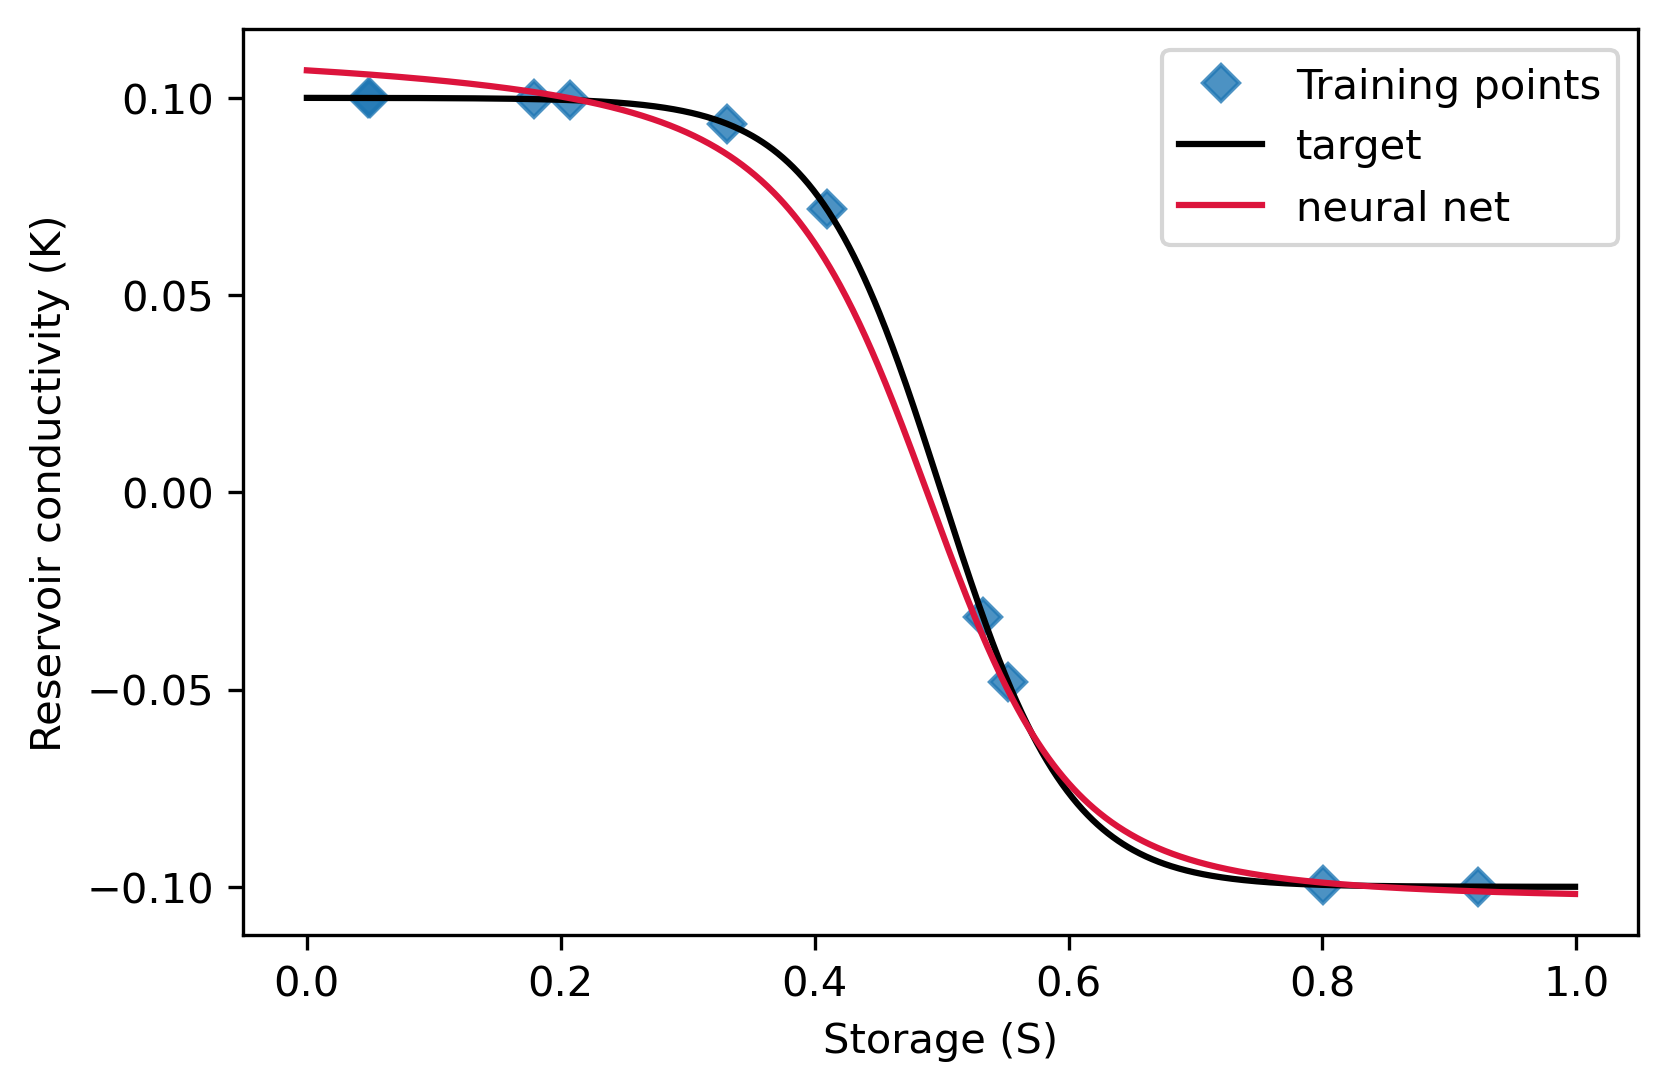

In [26]:
model = TorchDiffEqNeuralReservoir(width, depth).to(device)
loss_fun = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []
for i in tqdm(range(max_epochs)):
    train_loss = epoch(train_X, train_Y, model, loss_fun, opt)
    loss_history.append(train_loss)

v = torch.tensor(np.arange(0.0, 1.0, step=0.001), dtype=dtype)
plot_conductivity(model, v)

## Scaling up to a conceptual hydrologic model

### The system of equations
Now we have a working way to train differential equations parameterized by neural networks. It's time to move to something a bit more useful than the nonlinear reservoir example. We will develop a relatively simple conceptual hydrologic model with two storage buckets. We will allow drainage from the "surface" bucket to the "subsurface" bucket as well as "evapotranspiration" to come from the "surface" bucket. Streamflow will be considered the sum of the outflow of the two buckets. In mathematical terms we can write this as a system of equations:

$$
\frac{d}{dt} \begin{pmatrix}
S_{0}\\
S_{1}
\end{pmatrix} = 
\begin{pmatrix}
 P - ET - D - Q_{0} \\
 D - Q_{1}
\end{pmatrix}
$$

Where $S_{0}$ is the "surface" bucket, $S_{1}$ is the "subsurface" bucket, $P$ is precipitation, $ET$ is evapotranspiration, $D$ is drainage from the surface to the subsurface, and $Q_{0}$/$Q_{1}$ are the surface/subsurface discharge. Before defining how each of these calculations is done explicitly we will also define the following terminology for how certain parameters are handled:

$$
\left.\sigma\right|_{b}^{a}(x) = (a - b) \cdot \sigma(x) + b
$$

where $x$ is the name of the parameter, $\sigma$ is the sigmoid function, and $a$ and $b$ are the bounds of the parameter with $a>b$. This operation allows us to train the parameters, but not have to strictly constrain them to be roughly on the $\pm 1$ range. Essentially this is the sigmoid function scaled between $a$ and $b$ and is employed so that all underlying trainable parameters fall on the same range but can be translated to hydrologically relevant values. We implement this as the `HydroParam` module:

In [27]:
class HydroParam(nn.Module):
    
    def __init__(self, low, high, net):
        super().__init__()
        # `register_buffer` assigns variables which can be
        # used in training, but are not meant to be trainable values
        self.register_buffer('low', torch.tensor([low], dtype=dtype))
        self.register_buffer('high', torch.tensor([high], dtype=dtype))
        self.register_buffer('range', torch.tensor([high-low], dtype=dtype))
        self.net = net
        
    def forward(self, x):
        x = self.net(x)
        return self.range * torch.sigmoid(x) + self.low
    

To parameterize each of these terms we will follow some conventional approaches, namely a set of relations described in the Framework for Understanding Structural Errors (FUSE) model (**Clark et al., 2008**). Namely we will calculate ET as:

$$
ET = \left.\sigma\right|_0^1(p) \cdot PET \cdot \left( 
         \frac{S_{0}}
         {\left.\sigma\right|_{1}^{100}(S_{0, max})} 
     \right)
$$

where $p$ is the tunable parameter, and $PET$ is the reference potential evapotranspiration. We implement this equation via the `ETTerm`:

In [28]:
class ETTerm(nn.Module):
    
    def __init__(self, S0max, p):
        super().__init__()
        self.S0max = S0max
        self.p = p
        self.register_buffer('z', torch.tensor([0.0], dtype=dtype))
        
    def forward(self, x, S0, pet):
        S0max_val = self.S0max(x)
        p_val = self.p(x)
        et = p_val * pet * (S0 / S0max_val)
        et = torch.clamp(et, self.z, S0)
        return et
    

Drainage is calculated as:

$$
D = \left.\sigma\right|_{0.01}^{100}(k_{u}) 
    \cdot \left( \frac{S_{0}}{\left.\sigma\right|_{1}^{100}(S_{0, max})} \right) 
    ^ {\left.\sigma\right|_{0.01}^{10}(c)}
$$

where $k_u$ and $c$ are tunable parameters. We implement this as the `DrainageTerm`:

In [29]:
class DrainageTerm(nn.Module):
    
    def __init__(self, S0max, ku, c):
        super().__init__()
        self.S0max = S0max
        self.ku = ku
        self.c = c
        self.register_buffer('z', torch.tensor([0.0], dtype=dtype))
        
    def forward(self, x, S0):
        S0max_val = self.S0max(x)
        ku_val = self.ku(x)
        c_val = self.c(x)
        drainage = ku_val * (S0 / S0max_val) ** c_val
        drainage = torch.clamp(drainage, self.z, S0)
        return drainage
    

Surface flow $Q_{0}$ is calculated by estimating the saturated fraction ($A_{sat}$) as:

$$
A_{sat} = 1 - \left(1 -  \frac{S_{0}}{
         \left.\sigma\right|_{1}^{100}(S_{0, max})
} \right) ^{\left.\sigma\right|_{0.001}^{3.0}(b)}
$$

And the implementation via the `SaturatedAreaTerm` class:

In [30]:
class SaturatedAreaTerm(nn.Module):
    
    def __init__(self, S0max, b):
        super().__init__()
        self.S0max = S0max
        self.b = b
        self.register_buffer('z', torch.tensor([0.0], dtype=dtype))
        
    def forward(self, x, S0):
        S0max_val = self.S0max(x)
        b_val = self.b(x)
        ratio = torch.clamp(
            S0 / S0max_val,
            self.z,
            self.z + 1
        )
        return 1 - (1-ratio) ** b_val
    

The surface flow is simply calculated by multiplying the surface saturation by the incoming precipitation:

$$
Q_{0} = A_{sat} \cdot P
$$

And the implementation via the `SurfaceFlowTerm` class:

In [31]:
class SurfaceFlowTerm(nn.Module):
    
    def __init__(self, a_sat):
        super().__init__()
        self.a_sat = a_sat
        self.register_buffer('z', torch.tensor([0.0], dtype=dtype))
        
    def forward(self, x, S0, prcp):
        return torch.clamp(self.a_sat(x, S0) * prcp, self.z)
    

Finally, we define the subsurface flow as:

$$
Q_{1} = \left. \sigma \right|_{0.001}^{10}(k_s) \cdot \left( \frac{S_1}
         {\left.\sigma\right|_{1}^{100}(S_{1, max})} 
         \right) ^ {\left. \sigma\right|_{0.01}^{10}(n)}
$$

And the implementation viat the `SubsurfaceFlowTerm` class:

In [32]:
class SubsurfaceFlowTerm(nn.Module):
    
    def __init__(self, S1max, ks, n):
        super().__init__()
        self.S1max = S1max
        self.ks = ks
        self.n = n
        self.z = torch.tensor(0.0, dtype=dtype)
        
    def forward(self, x, S1):
        ks_val = self.ks(x)
        S1max_val = self.S1max(x)
        n_val = self.n(x)
        subsurf_flow = ks_val * (S1 / S1max_val) ** n_val
        return torch.clamp(subsurf_flow, self.z, S1max_val)
    

This defines all of the necessary fluxes for our conceptual hydrologic model! The model structure as defined here was taken from **Clark et al. (2008)** and was designed to be somewhat analogous to a simplified Variable Infiltration Capacity (VIC, **Liang et al., 1994**) type model, though lacking clear energy and water balance interaction terms as well as the obvious omission of snow and vegetation processes beyond a simple "lumped" ET quantity. The implementation of this is all wrapped into our `HydroEquation` class, as follows below. You'll note here that there are not any user-definable parameters, everything is learned! You might consider the ranges allowed on the parameter values as hyperparameter, but we will not consider trying to tune them specifically here. 

In [33]:
class HydroEquation(nn.Module):
    
    def __init__(
        self, S0max, S1max,
        p, ku, ks, c, b, n
    ):
        super().__init__()
        self.S0max = S0max
        self.S1max = S1max
        self.p = p
        self.ku = ku
        self.ks = ks
        self.c = c
        self.b = b
        self.n = n

        self.et_term = ETTerm(self.S0max, self.p)
        self.drainage_term = DrainageTerm(self.S0max, self.ku, self.c)
        self.saturated_area_term = SaturatedAreaTerm(self.S0max, self.b)
        self.surface_flow_term = SurfaceFlowTerm(self.saturated_area_term)
        self.subsurf_flow_term = SubsurfaceFlowTerm(self.S1max, self.ks, self.n)

    def forward(self, t, storage):
        S0, S1 = storage
        pet, prcp, *attrs = self.forcing
        x = torch.stack(attrs)
        self.et = self.et_term(x, S1, pet)
        self.drainage = self.drainage_term(x, S0)
        self.surface_flow = self.surface_flow_term(x, S0, prcp)
        self.subsurf_flow = self.subsurf_flow_term(x, S1)
        self.qtotal = (self.surface_flow + self.subsurf_flow)
            
        # Clamping enforces mass balance
        dS0_dt = torch.clamp(
            prcp - self.et - self.drainage - self.surface_flow,
            min=-S0,
            max=self.S0max(x) - S0
        )
        dS1_dt = torch.clamp(
            self.drainage - self.subsurf_flow,
            min=-S1,
            max=self.S1max(x) - S1
        )
        dS_dt = torch.hstack([dS0_dt, dS1_dt])
        return dS_dt       

As in the nonlinear reservoir network here we will also wrap up the `HydroEquation` class so that it's easier to extract what we want out of the solution to the ODE system. We'll call this the `HydroSimulator` since it solves the `HydroEquation` but allows us to see the time-evolution of the system by recording all of the necessary fluxes and states along the way.

In [34]:
class HydroSimulator(nn.Module):
    
    def __init__(
        self, S0max, S1max,
        p, ku, ks, c, b, n,
        method='euler',
    ):
        super().__init__()
        self.method = method
        self.register_buffer('t', torch.tensor([0, 1], dtype=dtype))
        self.ode = HydroEquation(
            S0max, S1max, p, ku,
            ks, c, b, n
        )

    def forward(self, forcing, storage):
        qtotal = []
        storage_ts = []
        surf_flow = []
        subsurf_flow = []
        drainage = []
        et = []
        for f in forcing:
            self.ode.forcing = f
            storage = odeint(self.ode, storage, self.t, method=self.method)
            storage = storage[-1].clone().detach()
            storage_ts.append(storage)
            qtotal.append(self.ode.qtotal)
            surf_flow.append(self.ode.surface_flow)
            subsurf_flow.append(self.ode.subsurf_flow)
            drainage.append(self.ode.drainage)
            et.append(self.ode.et)
        self.end_storage = storage
        self.storage_ts = torch.stack(storage_ts)
        self.surface_flow = torch.stack(surf_flow)
        self.subsurface_flow = torch.stack(subsurf_flow)
        self.drainage = torch.stack(drainage)
        self.et = torch.stack(et)
        return torch.stack(qtotal)

### Data

With the overall model structure out of the way we come to the real fork in the road - data! So far we've been working with synthetic data, or just idealized situations. But as hydrologists & Earth systems modelers we cannot live in fantasy land, so eventually must be confronted by the real world. This means we need some basic infrastructure for training (aka calibrating) the model structure we've designed against something closer to reality. This requires two basic components. First, the actual raw data - for this, we'll use a subset of the CAMELS dataset (**Newman et al., 2015; Addor et al., 2017**). For this chapter we will only train for a single basin, but we include data for multiple basins for you to explore. The CAMELS dataset contains a wide range of hydroclimatic conditions in basins which are minimally impacted by human infrastructure and have long records of streamflow observations. 

As our model contains no explicit store for snow we will take some time to filter out basins where snowpack is a dominant factor. However, since we don't have actual observed snow data for these basins to filter with we will use daily minimum temperature as a proxy. To do so, we simply filter out any basins where the 10th percentile of daily minimum temperature during the winter months is below 0 degrees C. The code below opens up the provided NetCDF dataset via xarray and converts all of the data to `float32`, which is done to improve memory usage and computational speed. We then calculate the winter low temperatures using a `groupby` approach, which allows us to concisely find which basins whic hmeet the criteria specified earlier. We then do so using the `.where` method, and finally select the basins we want using the `.sel` method. As you can see the final dataset printed out still has 131 basins, each with 10 water years of data. 

This dataset contains a number of pre-run results from other hydrologic models, forcing variables such as daylength (`dayl`), precipitation (`prcp`), daily minimum and maximum temperatures (`Tmin` and `Tmax`), and potential evapotranspiration (`pet`) among others. Additionally there are a number of basin specific attributes such as basin area (`area`), basin average elevation (`elevation`), and aridity (`aridity`).

In [35]:
ds = xr.open_dataset('./data/camels_data.nc').astype(np.float32).load()
low_temp = (ds['Tmin']                        # Select daily min temp
              .groupby(ds['time'].dt.season)  # Group it into seasons
              .quantile(q=0.10)               # Get the 10th %-ile value
              .sel(season='DJF'))             # Grab winter month vals

# Select only the basins where the winter lows are above 0C.
warm_basins = ds['hru'].where(low_temp > 0, drop=True)
ds = ds.sel(hru=warm_basins).drop(['quantile', 'season'])
ds['elevation'] = ds['elevation'] / 1000
ds['area'] = ds['area'] / 1000
ds

<xarray.Dataset>
Dimensions:         (hru: 131, time: 3652)
Coordinates:
  * hru             (hru) int64 7292500 2342933 8158810 ... 2245500 2430085
  * time            (time) datetime64[ns] 1989-10-01 1989-10-02 ... 1999-09-30
Data variables: (12/25)
    QObs            (hru, time) float32 1.525 0.7277 0.4899 ... 0.1324 0.1384
    HBV_lb          (hru, time) float32 1.173 1.067 0.9227 ... 0.1385 0.1369
    HBV_ub          (hru, time) float32 1.183 0.9443 0.8918 ... 0.05157 0.05042
    SAC_SMA         (hru, time) float32 0.4151 0.4034 0.4005 ... 0.2743 0.2674
    VIC_basin       (hru, time) float32 2.532 1.31 0.7074 ... 0.1104 0.09831
    q_sim_fuse_900  (hru, time) float32 1.912 1.048 0.7786 ... 0.17 0.1467
    ...              ...
    frac_forest     (hru) float32 0.9468 0.9083 0.0548 ... 0.963 0.8235 0.8644
    p_mean          (hru) float32 4.256 3.815 2.509 2.232 ... 5.819 3.756 4.233
    pet_mean        (hru) float32 3.475 3.275 3.377 3.811 ... 2.838 3.81 2.947
    aridity         (hru) float32 0.8166 0.8586 1.346 ... 0.4877 1.014 0.6963
    Tavg            (hru, time) float32 21.31 22.92 24.86 ... 25.7 22.33 14.51
    pet             (hru, time) float32 3.207 5.699 5.843 ... 3.261 2.623 4.953

Now that we've got a dataset to use we need a way of ingesting it so that we can actually train the model. To do so we will employ a slightly non-standard technique called "multiple trajectory", or "multiple shooting", optimization. The problem is essentially that the model we defined above is somewhat analagous to a recurrent neural network (RNN), where to train we iterate over sequences with some length. In this case the sequences are multiple timesteps. Like RNNs, you don't want to update the model parameters after every step because that makes the training process almost impossible. Instead, we run the model forward in time for some period of time, then update the model parameters according to the accumulated gradients. In principle, we could run the model over the entire training period, but this is means fewer data points to update the model parameters, leading to slower convergence. Instead, we break the full dataset into a series of "trajectories" which contain a specified time period. Then, during the training process we iterate over each of these trajectories, updating model parameters along the way. A full pass over all of the trajectories, then, is a single training epoch.

We implement this below. This sort of data-wrangling is core to doing machine learning, so thinking about how and why to arrange data any particular way is very important. As such, we build on the PyTorch `Dataset` class, which simplifies the interface to referencing data for both training and inference (commonly referred to as prediction). Without getting too far into the weeds of data loading we just set up the way to index the dataset via the `__getitem__` method and ways to determine how bid the dataset is through the `__len__` method. 


Finally, let's talk about what actually comes out of the dataset. When you index on the dataset (as `x[i]`) you will get two tensor arrays back. The first is the input to the model, and the second is the target data that we want the model to produce when given the input. In our case we will record the inputs and outputs via the `in_vars` and `out_vars` variables. This will make it easier to explore which variables have an impact during training.

> ### On `__dunder__` methods
> The methods that we implemented in the `MultipleTrajectoryDataset` are referred to as "dunder" (aka double underscore) methods which python uses to call the base indexing calls. Simply stated, if you call `x[i]` you are really calling `x.__getitem__(i)` and if you call `len(x)` you are really calling `x.__len__()`. Of course these are simplifications, but the shorthand is useful to understand.

In [36]:
class MultipleTrajectoryDataset(Dataset):
    
    def __init__(self, ds, in_vars, out_vars, trajectory_len):
        super().__init__()
        self.ds = ds.load().drop('hru')
        self.in_vars = in_vars
        self.out_vars = out_vars
        self.trajectory_len = trajectory_len
        self.n_trajectories = int(len(self.ds['time']) / self.trajectory_len)
        self.time_starts = [i * trajectory_len 
                            for i in range(self.n_trajectories)]
        self.time_ends = [(i+1) * trajectory_len 
                          for i in range(self.n_trajectories)]
        
    def __getitem__(self, idx):
        time_slice = slice(self.time_starts[idx], self.time_ends[idx])
        sample_ds = self.ds.isel(time=time_slice)
        x = torch.from_numpy(sample_ds[self.in_vars].to_dataframe().values)
        y = torch.from_numpy(sample_ds[self.out_vars].to_dataframe().values)
        return x, y
    
    def __len__(self):
        return len(self.time_starts)

### The model training functions

With a model and dataset in hand we will define some functions to simplify the core training loop. First the `update_model_step` function is used to actually perform the optimization step. This is pretty much a standard update function where we run the model on some training data, compute the loss, and use the gradients of the loss with respect to the parameters to update the parameters via the optimizer's `step` method. The other function we define is the `update_ic_step` which is where we update the initial conditions (that is, the initial storages) at the end of an individual training trajectory. This is calculated after `update_model_step` and used to transition between training trajectories.

In [37]:
def update_model_step(
    model, opt, train_data, S_init, 
    loss_fun=torch.nn.MSELoss(), device=device
):
    Xd, yd = train_data
    Xd = Xd.to(device)
    yd = yd.to(device)
    opt.zero_grad()
    yp = model(Xd, storage=S_init)
    loss = loss_fun(yp.squeeze(), yd.squeeze())
    loss.backward()
    opt.step()
    return loss

def update_ic_step(model, train_data, S_init):
    forcing, q_true = train_data
    q_pred  = model(forcing, storage=S_init)
    final_storage = model.end_storage.clone().detach()
    return final_storage

### Setting up our training/testing data
Now that we've got everything we need to do the training let's go ahead and set up our process. First, we need to select a basin that we want to train at, select out the train and test timeframes, and then create the dataset with some trajectory lengths (in units of days). Finally we create a `MultipleTrajectoryDataset` for our training and testing periods.

In [38]:
# HRU that tend to perform well
# 14166500 , 14306500, 11476600 , 14306500 ,11532500, 11143000 
# HRU that tend to perform poorly
# 7292500 , 2102908, 8155200, 2212600
selected_basin = 11143000

train_time = slice('10-01-1989', '09-30-1996')
test_time = slice('10-01-1997', '09-30-1999')
train_ds = ds.sel(hru=selected_basin, time=train_time)
test_ds  = ds.sel(hru=selected_basin, time=test_time)

seq_len = 365
attrs = [
    'elevation',
    'area',
    'frac_forest',
    'aridity'
]
in_vars = ['pet', 'prcp'] + attrs
out_vars = ['QObs']

# Training dataset
train_data = MultipleTrajectoryDataset(
    train_ds, in_vars, out_vars,  seq_len
)

# Test dataset
test_data = MultipleTrajectoryDataset(
    test_ds, in_vars, out_vars, len(test_ds['time'])
)

### Defining the model setup

Now we set some hyperparameters, which are our the neural network width and depth for each parameterization defined previously, initial storage values, the learning rate, and the bounds of the physical constants of each parameter for the `HydroSimulator`. The initial storage warrants some discussion. In our testing this can actually have a decent impact on the overall performance, so if you try different basins you might fiddle with this to see if you can get better performance. We have set up some infrastructure in our training loop that minimizes this effect, but it is still present to some extent.

The way that we mitigate some of the impact of the choice of the `initial_storage` values is after a full epoch (that is, a pass over each of the training trajectories) we take the average of the ending storage values and use that as the initial storage for the next epoch. 

Following that we set the hyperparameters for the `HydroParam` objects which represent parameter values for the model. We have simply set all of them to be single layer MLPs with 6 nodes. You can try to adjust this, but since we are training on a single basin with only static attributes the model complexity does not actually have a large impact on model performance. The actual bounds on each of the `HydroParam` instances was taken more or less from the recommendations from the original implementation of this conceptual model by **Clark et al. (2008)**.

With the hyperparameters set up, we will create our model instance and set the optimizer. Here we'll just use the Adam optimizer and mean squared error losses as they're a good all around picks, but you can explore different options here as well. The learning rate was chosen by trial and error, and seems to work well enough.

In [39]:
initial_storage = torch.tensor([30.0, 50.0], dtype=torch.float32)

width = 6
depth = 1
in_dim = len(attrs)

S0max = HydroParam( 50.000, 200.0, MLP(width, depth, in_dim=in_dim))
S1max = HydroParam(100.000, 500.0, MLP(width, depth, in_dim=in_dim))
p     = HydroParam(  0.001,   1.5, MLP(width, depth, in_dim=in_dim))
ku    = HydroParam(  0.010, 100.0, MLP(width, depth, in_dim=in_dim))
ks    = HydroParam(  0.010, 100.0, MLP(width, depth, in_dim=in_dim))
b     = HydroParam(  0.001,   3.0, MLP(width, depth, in_dim=in_dim))
c     = HydroParam(  0.010,  10.0, MLP(width, depth, in_dim=in_dim))
n     = HydroParam(  0.010,  10.0, MLP(width, depth, in_dim=in_dim))

model = HydroSimulator(S0max, S1max, p, ku, ks, b, c, n).to(device)
model.to(device)

learning_rate = 3e-3
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fun = torch.nn.MSELoss() 

### Training the model

Now, finally, we get to train the model. The "training loop" here consists of three actual python loops. The first is for overall epochs, which is the number of times that we pass over the full dataset. The second is to pass over each of our training trajectories. And, finally, the third is the number of times that we look at an individual trajectory before moving to the next. For each inner-most loop (that is passes over the same trajectory) we compute the training loss. Once we have moved onto a new trajectory we record the ending storages so that they can be supplied to the next trajectory as an initial condition. This is how we use the multiple trajectory training to work around the fact that we do not know the actual values for the storages in the upper and lower layers at any given time, and particularly at the initial times of each trajectory, and is done by calling `update_ic_step` after the innermost training loop has completed. In our case, training may take a couple of minutes.

In [40]:
max_epochs = 6        # Number of times we pass over the full training set
max_sub_epochs = 2    # Number of times we pass over each trajectory 
train_loss_history = {i: [] for i in range(len(train_data))}
for epoch in tqdm(range(max_epochs)):
    storage = initial_storage.clone().to(device)
    for idx_traj in np.arange(len(train_data)):
        for sub_epoch in range(max_sub_epochs):
            # Get the training data for this trajectory
            data = train_data[idx_traj]
            # Train on the current trajectory
            l = update_model_step(model, opt, data, storage.clone())
            train_loss_history[idx_traj].append(l.detach().cpu().numpy())
        # Update the storage for the next trajectory
        storage = update_ic_step(model, data, storage.clone())


  0%|          | 0/6 [00:00<?, ?it/s]

As you can see from the training curves we were able to reduce the loss relatively quickly. Additionally you see that each of the trajectories (which are different periods of time) end up with different loss curves. You can see then that some years are harder for the model than others, although all show improvement over their starting point. You might look at these trajectories individually to see if you can diagnose why some trajectories are easier to optimize than others. You may also notice that this training process did not converge to a minimum. We cut the training time off here because we wanted to provide a simple and efficient example for you to be able to tinker with.

[]

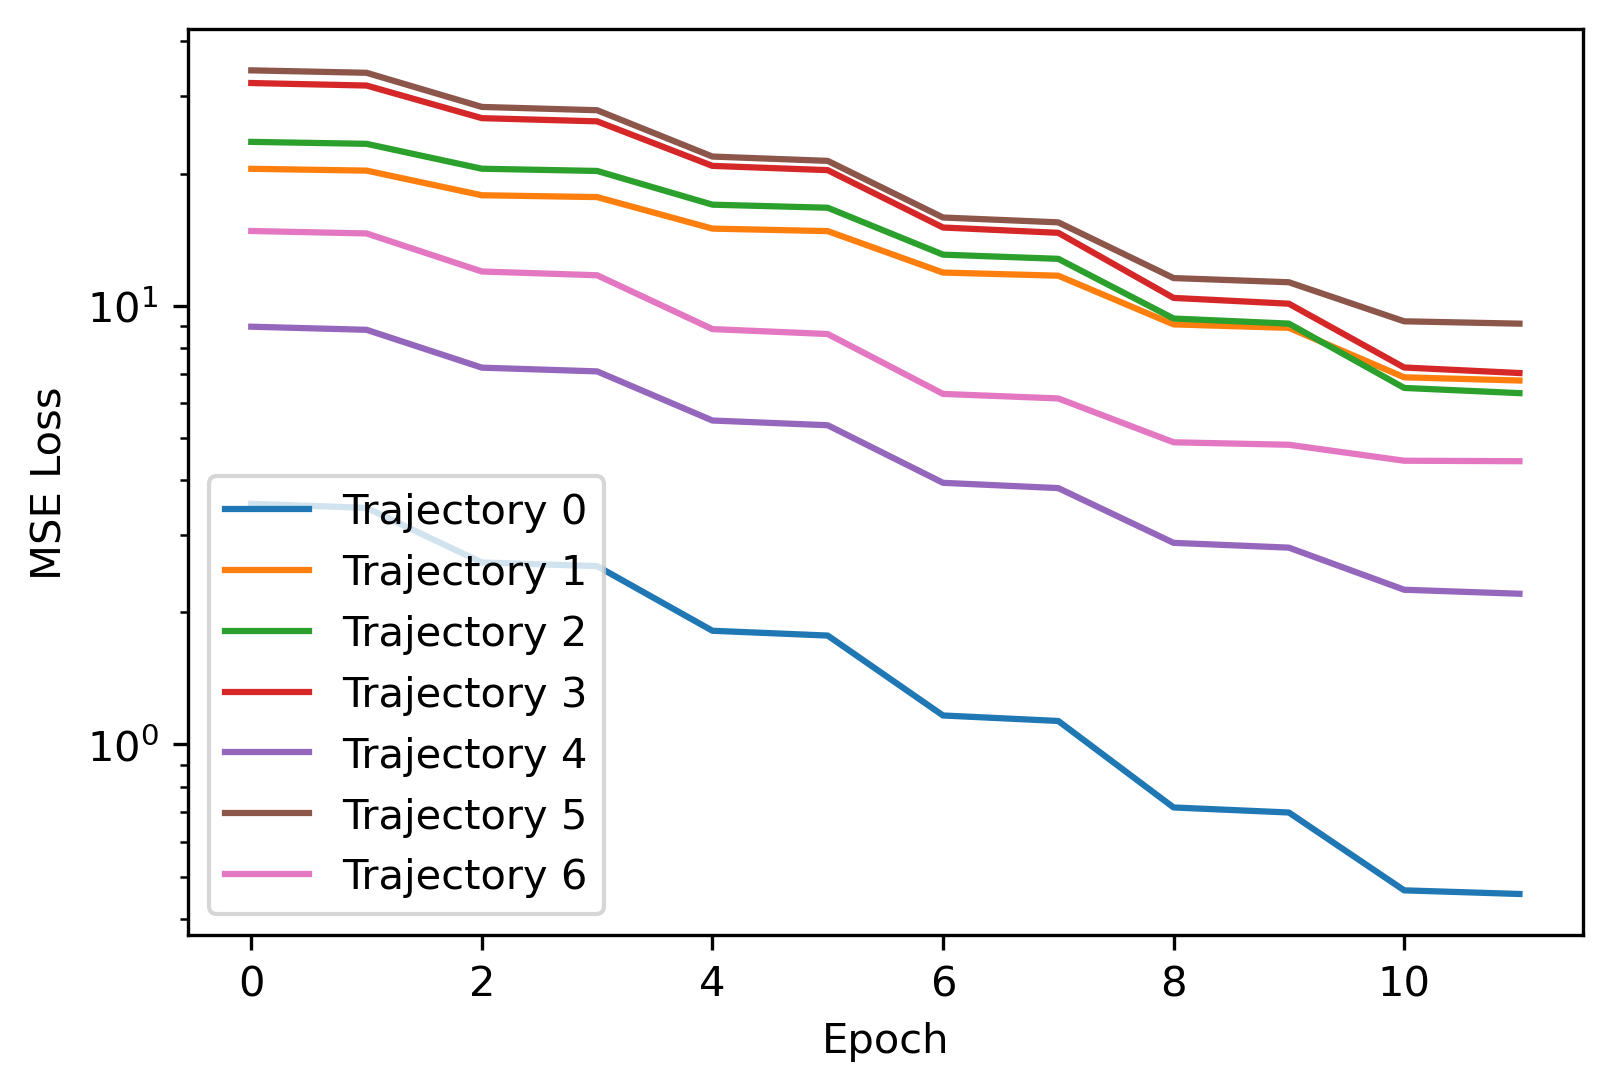

In [41]:
for k, v in train_loss_history.items():
    plt.plot(v, label=f'Trajectory {k}')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.semilogy()

### Model analysis

With the model trained we can now run it on the test data and see what we've produced. Before analyzing the model we'll define the `nse` function which calculates the Nash-Sutcliffe efficiency which is a measure of performance **(Nash & Sutcliffe, 1970)**. Values above 0 indicate that the model does better than simply using the observed mean while a value of 1 is a perfect match.

In [42]:
def nse(sim, obs):
    return (1 - (np.sum((obs - sim) ** 2) 
            / np.sum((obs - np.mean(obs)) ** 2)))

To actually run the model we pull our forcings (that is, daily precipitation and potential-evapotranspiration) and observed streamflow from the `test_data`. The forcings can then be put into the model, with the average storage from training as our starting place. We first run the trained model to get the predicted streamflow as well as pull out the relevant storage terms and fluxes. 

In [43]:
x, y = test_data[0]
x = x.to(device)
initial_storage = model.end_storage.clone().detach()

forcing = to_np(x)
q_true = to_np(y)
q_pred = to_np(model(x, initial_storage))

surf_storage = to_np(model.storage_ts[:, 0])
subsurf_storage = to_np(model.storage_ts[:, 1])

surf_flow = to_np(model.surface_flow)
subsurf_flow = to_np(model.subsurface_flow)

et = to_np(model.et)
drainage = to_np(model.drainage)

Next, we can plot all of the data to see what's going on in the model. There are a number of interesting things to discuss in the model outputs, but obviously the first thing you will look at is how well the predicted streamflow matches the observed streamflow. If you are using the basin we selected as default you will find we get a value of about 0.71, which is a quite reasonably performing model. Not bad for such a simple setup! 

You can also look at the storage timeseries, which shows the internal dynamics of the system. Overall we see slower dynamics in the subsurface, which is reasonable. Further, we see that the subsurface in this model configuration retains quite a bit of water as a "steady state". The surface bucket, on the other hand, reacts much more quickly to precipitation inputs and seems to help produce the "flashy" streamflow events, as you would suspsect. 

Finally, looking at the ET/PET ratios we see that generally the ratio is maximized when moisture is high in the system, while the ratio becomes lower in the dry periods, despite a high demand. Again all of this is reasonable for a hydrologic model. But the key difference here is that our parameter values were represented by neural-networks rather than single numbers.

Text(0.5, 0, 'Day of prediction')

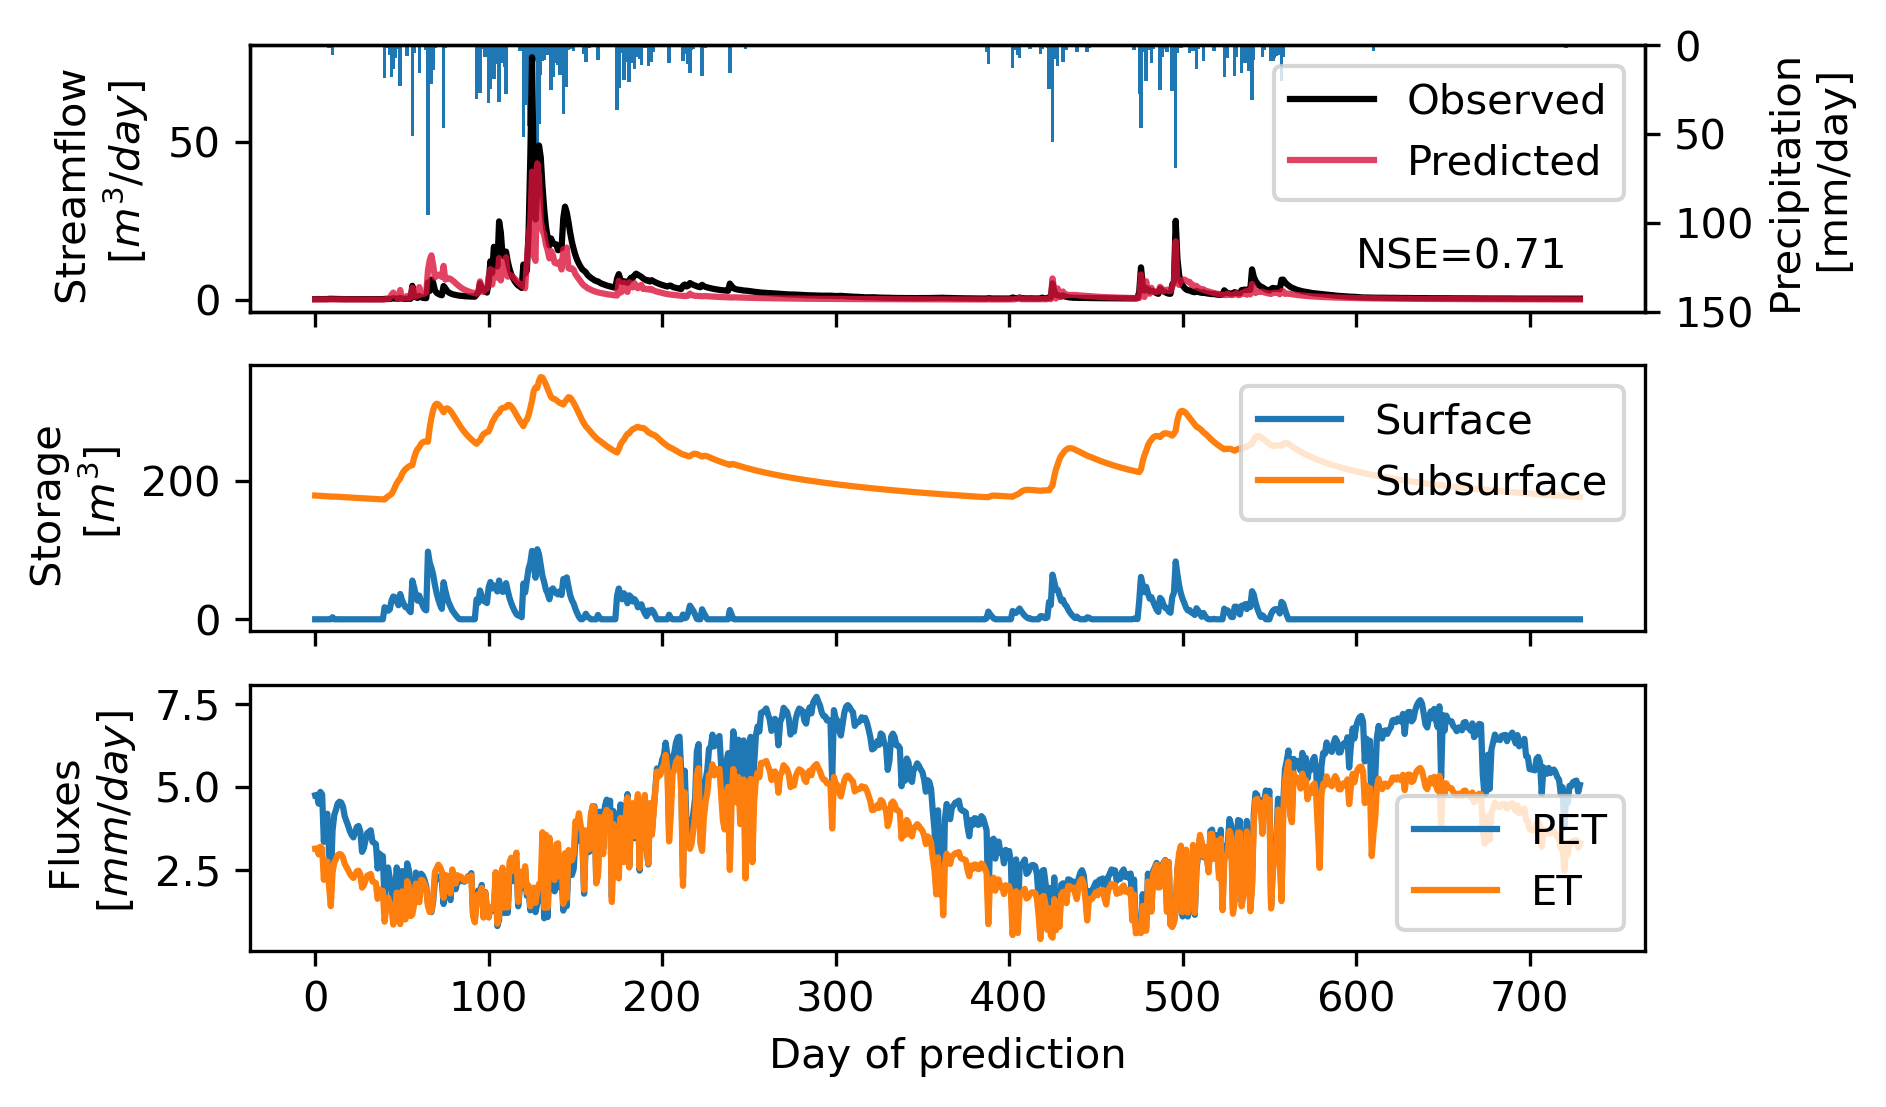

In [44]:
fig, axes = plt.subplots(3, 1, sharex=True)
times= np.arange(len(forcing[:, 1]))
p_ax = axes[0].twinx()
p_ax.invert_yaxis()
p_ax.bar(times, forcing[:, 1], label='Precipitation', width=2)
p_ax.set_ylim([150, 0])

axes[0].set_zorder(100)
axes[0].patch.set_visible(False)
axes[0].plot(q_true, alpha=1.0, color='black', label='Observed')
axes[0].plot(q_pred, alpha=0.8, color='crimson', label='Predicted')
axes[0].set_ylabel('Streamflow \n [$m^3/day$]')
p_ax.set_ylabel('Precipitation \n [mm/day]')
axes[0].legend(loc='upper right')
axes[0].text(
    600, 10 , f'NSE={np.around(nse(q_pred[i:], q_true[i::]), 2)}'
)

axes[1].plot(surf_storage, label='Surface')
axes[1].plot(subsurf_storage, label='Subsurface')
axes[1].set_ylabel('Storage \n [$m^3$]')
axes[1].legend(loc='upper right')

axes[2].plot(forcing[:, 0], label='PET')
axes[2].plot(et, label='ET')
axes[2].set_ylabel('Fluxes \n [$mm/day$]')
axes[2].legend(loc='lower right')
axes[2].set_xlabel('Day of prediction')


### 6. Conclusions

In this chapter we hope you have learned that the numerical modeling approaches in traditional hydrologic models is not so different from than those of machine learning (particularly with respect to ODE based models). The conceptual model that we formulated within the pytorch framework was able to be trained with standard optimizers via backpropagation. While the final model we trained is not state of the art in performance we hope that seeing it built up from base principles demystifies many aspects of merging physics with machine learning. 

#### 6.1 Assignments

To this end we offer some possible modifications and extensions of the work that we've described above that we hope sparks your own work.

1. Rather than working the nonlinear reservoir, can you replace the ODE with other classical examples? Perhaps try things like a forced/damped oscillator or projectile motion. How might you handle something like a reservoir with hysteresis where filling has different trajectories than draining?

2. Consider how you might adapt storage-discharge relations to a more readily observed area-elevation relation from satellite imagery of reservoirs. Do you think you could reconstruct operations curves from such observations?

3. How would you extend the `HydroEquation` module to include more storage buckets? What if this was a configurable option? What about including a store for snow processes? Or a specific vegetation store to account for canopy storage?

4. Could you extend the `HydroEquation` to take in time-dependent quantities as inputs? Perhaps you could start with including the precipitation and potential evapotranspiration as input variables.

4. Consider spatially explicit subsurface representations. Could such methods possibly be used to learn subsurface properties?

#### 6.2 Open questions

We hope that our simple worked examples are enough for you to be able to modify and expand into code that is useful for your own research. In doing so, there are clearly many open questions. For instance, a natural extension of the final model would be to replace the parameters with more complex neural networks such as Long-Short-Term-Memory (LSTM) networks. Would it be possible to feed such networks with data from multiple basins to produce a global model as has been possible with Long-Short-Term-Memory (LSTM) models? There is also the question of adding on pre/post processing networks which could enhance predictive capabilities, yet retain the ability to model internal states in a physically satisfying way that moves the needle closer to "best of both worlds" with respect to the interpretibility-predictive spectrum.

### References

Addor, N., Newman, A. J., Mizukami, N., & Clark, M. P. (2017). The CAMELS data set: catchment attributes and meteorology for large-sample studies. Hydrol. Earth Syst. Sci., 21.

Bennett, A., & Nijssen, B. (2021). Deep Learned Process Parameterizations Provide Better Representations of Turbulent Heat Fluxes in Hydrologic Models. Water Resources Research, 57(5), e2020WR029328. https://doi.org/10.1029/2020WR029328

Beucler, T., Pritchard, M., Rasp, S., Ott, J., Baldi, P., & Gentine, P. (2020). Enforcing Analytic Constraints in Neural-Networks Emulating Physical Systems. ArXiv:1909.00912 [Physics]. Retrieved from http://arxiv.org/abs/1909.00912

Brenowitz, N. D., & Bretherton, C. S. (2018). Prognostic Validation of a Neural Network Unified Physics Parameterization. Geophysical Research Letters, 45(12), 6289–6298. https://doi.org/10.1029/2018GL078510

Chen, R. T. Q., Rubanova, Y., Bettencourt, J., & Duvenaud, D. (2018). Neural Ordinary Differential Equations. ArXiv:1806.07366 [Cs, Stat]. Retrieved from http://arxiv.org/abs/1806.07366

Clark, M. P., Slater, A. G., Rupp, D. E., Woods, R. A., Vrugt, J. A., Gupta, H. V., et al. (2008). Framework for Understanding Structural Errors (FUSE): A modular framework to diagnose differences between hydrological models. Water Resources Research, 44(12). https://doi.org/10.1029/2007WR006735


Feigl, M., Herrnegger, M., Klotz, D., & Schulz, K. (2020). Function Space Optimization: A Symbolic Regression Method for Estimating Parameter Transfer Functions for Hydrological Models. Water Resources Research, 56(10), e2020WR027385. https://doi.org/10.1029/2020WR027385

Feigl, Moritz, Roesky, B., Herrnegger, M., Schulz, K., & Hayashi, M. (2022). Learning from mistakes—Assessing the performance and uncertainty in process-based models. Hydrological Processes, 36(2), e14515. https://doi.org/10.1002/hyp.14515

Frame, J., Nearing, G., Kratzert, F., & Rahman, M. (2020). Post processing the U.S. National Water Model with a Long Short-Term Memory network (preprint). EarthArXiv. https://doi.org/10.31223/osf.io/4xhac

Gauch, M., Kratzert, F., Klotz, D., Nearing, G., Lin, J., & Hochreiter, S. (2021). Rainfall–runoff prediction at multiple timescales with a single Long Short-Term Memory network. Hydrology and Earth System Sciences, 25(4), 2045–2062. https://doi.org/10.5194/hess-25-2045-2021

Ian Goodfellow, Yoshua Bengio, & Aaron Courville. (2016). Deep Learning. MIT Press. Retrieved from https://mitpress.mit.edu/books/deep-learning

Isaacson, E., & Keller, H. B. (1994). Analysis of numerical methods. New York: Dover Publications.

Jiang, S., Zheng, Y., & Solomatine, D. (2020). Improving AI System Awareness of Geoscience Knowledge: Symbiotic Integration of Physical Approaches and Deep Learning. Geophysical Research Letters, 47(13), e2020GL088229. https://doi.org/10.1029/2020GL088229

Jiang, S., Zheng, Y., Wang, C., & Babovic, V. (2022). Uncovering Flooding Mechanisms Across the Contiguous United States Through Interpretive Deep Learning on Representative Catchments. Water Resources Research, 58(1), e2021WR030185. https://doi.org/10.1029/2021WR030185

Kingma, D. P., & Ba, J. (2017). Adam: A Method for Stochastic Optimization. ArXiv:1412.6980 [Cs]. Retrieved from http://arxiv.org/abs/1412.6980

Kochenderfer, M., & Wheeler, T. (n.d.). Algorithms for Optimization | The MIT Press. Retrieved April 30, 2022, from https://mitpress.mit.edu/books/algorithms-optimization

Konapala, G., Kao, S.-C., Painter, S. L., & Lu, D. (2020). Machine learning assisted hybrid models can improve streamflow simulation in diverse catchments across the conterminous US. Environmental Research Letters, 15(10), 104022. https://doi.org/10.1088/1748-9326/aba927

Kraft, B., Jung, M., Körner, M., Koirala, S., & Reichstein, M. (2021). Towards hybrid modeling of the global hydrological cycle (preprint). Global hydrology/Modelling approaches. https://doi.org/10.5194/hess-2021-211

Kraft, B., Jung, M., Körner, M., Koirala, S., & Reichstein, M. (2022). Towards hybrid modeling of the global hydrological cycle. Hydrology and Earth System Sciences, 26(6), 1579–1614. https://doi.org/10.5194/hess-26-1579-2022

Kratzert, F., Klotz, D., Herrnegger, M., Sampson, A. K., Hochreiter, S., & Nearing, G. S. (2019). Toward Improved Predictions in Ungauged Basins: Exploiting the Power of Machine Learning. Water Resources Research, 55(12), 11344–11354. https://doi.org/10.1029/2019WR026065

Krishnapriyan, A. S., Gholami, A., Zhe, S., Kirby, R. M., & Mahoney, M. W. (2021). Characterizing possible failure modes in physics-informed neural networks. ArXiv:2109.01050 [Physics]. Retrieved from http://arxiv.org/abs/2109.01050

Liang, X., Lettenmaier, D. P., Wood, E. F., & Burges, S. J. (1994). A simple hydrologically based model of land surface water and energy fluxes for general circulation models. Journal of Geophysical Research: Atmospheres, 99(D7), 14415–14428. https://doi.org/10.1029/94JD00483

Mai, J., Shen, H., Tolson, B. A., Gaborit, É., Arsenault, R., Craig, J. R., et al. (2022). The Great Lakes Runoff Intercomparison Project Phase 4: the Great Lakes (GRIP-GL). Hydrology and Earth System Sciences, 26(13), 3537–3572. https://doi.org/10.5194/hess-26-3537-2022

Nash, J. E., & Sutcliffe, J. V. (1970). River flow forecasting through conceptual models part I — A discussion of principles. Journal of Hydrology, 10(3), 282–290. https://doi.org/10.1016/0022-1694(70)90255-6

Nearing, G. S., Kratzert, F., Sampson, A. K., Pelissier, C. S., Klotz, D., Frame, J. M., et al. (n.d.). What Role Does Hydrological Science Play in the Age of Machine Learning? Water Resources Research, n/a(n/a), e2020WR028091. https://doi.org/10.1029/2020WR028091

Newman, A. J., Clark, M. P., Sampson, K., Wood, A., Hay, L. E., Bock, A., et al. (2015). Development of a large-sample watershed-scale hydrometeorological data set for the contiguous USA: data set characteristics and assessment of regional variability in hydrologic model performance. Hydrology and Earth System Sciences, 19(1), 209–223. https://doi.org/10.5194/hess-19-209-2015

Nocedal, J., & Wright, S. J. (2006). Numerical optimization (2nd ed). New York: Springer.

Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., et al. (2019, December 3). PyTorch: An Imperative Style, High-Performance Deep Learning Library. arXiv. Retrieved from http://arxiv.org/abs/1912.01703

Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations. Journal of Computational Physics, 378, 686–707. https://doi.org/10.1016/j.jcp.2018.10.045

Rasp, S., Pritchard, M. S., & Gentine, P. (2018). Deep learning to represent subgrid processes in climate models. Proceedings of the National Academy of Sciences, 115(39), 9684–9689. https://doi.org/10.1073/pnas.1810286115

Ruder, S. (2017, June 15). An overview of gradient descent optimization algorithms. arXiv. Retrieved from http://arxiv.org/abs/1609.04747

Schaeffer, H. (2017). Learning partial differential equations via data discovery and sparse optimization. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Science, 473(2197), 20160446. https://doi.org/10.1098/rspa.2016.0446

Shen, C. (2018). A Transdisciplinary Review of Deep Learning Research and Its Relevance for Water Resources Scientists. Water Resources Research, 54(11), 8558–8593. https://doi.org/10.1029/2018WR022643

Thapa, S., Zhao, Z., Li, B., Lu, L., Fu, D., Shi, X., et al. (2020). Snowmelt-Driven Streamflow Prediction Using Machine Learning Techniques (LSTM, NARX, GPR, and SVR). Water, 12(6), 1734. https://doi.org/10.3390/w12061734

Tian, Y., Xu, Y.-P., Yang, Z., Wang, G., & Zhu, Q. (2018). Integration of a Parsimonious Hydrological Model with Recurrent Neural Networks for Improved Streamflow Forecasting. Water, 10(11), 1655. https://doi.org/10.3390/w10111655

Xingyuan Chen, Peishi Jiang, Justine E.C. Missik, Zhongming Gao, Brittany Verbeke, & Heping Liu. (2020). Opening the black box of LSTM models using XAI. Presented at the American Geophysical Union Fall Meeting, Virtual: American Geophysical Union.

Yuan-Heng, W., Link to external site,  this link will open in a new window, Gupta, H. V., Zeng, X., Niu, G., & Link to external site,  this link will open in a new window. (2021). Exploring the Potential of Long Short-Term Memory Networks for Improving Understanding of Continental- and Regional-Scale Snowpack Dynamics. Earth and Space Science Open Archive ESSOAr. http://dx.doi.org/10.1002/essoar.10507610.1
